# Assignment 2: Working with health data from wearables

Iris Vukovic

## Data

In this assigment you will use the [Daily Sports and Activities](http://archive.ics.uci.edu/ml/datasets/Daily+and+Sports+Activities) dataset from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.html). This dataset contains motion sensor data of 19 daily and sports activities (walking, running, rowing, jumping,...), each performed by 8 subjects in their own style for 5 minutes. Five Xsens MTx units are used on the torso, (right and left) arms, and (right and left) legs. 

----

## Objectives

- Understand time-series health data
- Perform pre-processing and visualisation on time-series data
- Extract features from time-series data
- Train a classifier to predict the activity the users are doing

----

## Exercise 1

Load, analyse and visualise the (temporal) data of the different sensors for subject 7 (p7). Compare walking on a treadmill with a speed of 4 km/h on a flat surface (a10) and running on a treadmill with a speed of 8 km/h (a12). Do you see any difference? Comment.
 

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
%matplotlib inline

### Loading the data for subject 7

In [3]:
path = "/Users/irisvuko/Downloads/ds for health/data_for_ass2/" #path to the data folder 

In [22]:
segments_all_activities = []

for activity in range(1, 20):  
    for segment in range(1, 61):  
        #construct the filename for each segment
        segment_filename = f"a{activity:02d}/p7/s{segment:02d}.txt"  
        
        #construct the full path to the segment file
        segment_path = os.path.join(path, segment_filename)
        
        #load the data from each segment into a DataFrame
        df_segment = pd.read_csv(segment_path, header=None)
        
        #add a column for activity and segment to identify them
        df_segment['Activity'] = f'a{activity:02d}'  
        df_segment['Segment'] = segment  
        
        #append the DataFrame to the list
        segments_all_activities.append(df_segment)

#concatenate all the segments for all activities into a single DataFrame
df_all_activities_p7 = pd.concat(segments_all_activities, ignore_index=True)

df_all_activities_p7.shape

(142500, 47)

In [23]:
df_all_activities_p7

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,Activity,Segment
0,9.4422,-0.83385,2.63470,0.161510,0.085948,-0.110080,-1.09670,-0.37686,-0.31075,3.27050,...,-8.91250,-2.82750,-0.039431,-0.028901,-0.024591,0.28619,0.48345,0.68776,a01,1
1,9.3350,-1.27150,3.01150,-0.127700,0.046165,-0.088423,-1.09330,-0.38062,-0.31032,3.19200,...,-8.88250,-2.90900,-0.015363,-0.006716,0.004426,0.28523,0.48146,0.68883,a01,1
2,9.3941,-1.42720,2.90650,-0.106120,-0.002641,-0.106430,-1.09240,-0.38374,-0.31372,3.18150,...,-8.89750,-2.87950,0.022474,-0.002878,0.009793,0.28509,0.48055,0.68858,a01,1
3,9.1714,-1.34320,2.72630,-0.033600,0.059488,-0.037313,-1.09210,-0.38443,-0.31689,3.25770,...,-8.88260,-2.86450,0.048629,-0.008161,0.009693,0.28493,0.48225,0.68854,a01,1
4,9.1710,-1.38800,2.81550,-0.089161,0.039061,0.015597,-1.08970,-0.38437,-0.31998,3.35830,...,-8.91260,-2.79040,0.056076,0.013104,-0.003735,0.28492,0.48397,0.68692,a01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142495,10.7360,0.64092,3.52790,1.709300,-0.159030,-0.044742,-0.80862,-0.18206,-0.68150,1.32070,...,-3.74880,-1.65730,-1.557500,0.718820,0.603520,0.86720,0.34789,0.43108,a19,60
142496,10.8120,0.84615,0.19500,-0.194650,-1.013500,-0.266340,-0.82136,-0.18973,-0.66228,1.88840,...,-0.56696,-0.80663,-0.723030,0.543770,0.300150,0.86238,0.32128,0.46488,a19,60
142497,8.9354,-0.52650,-2.91670,0.212120,-0.177500,-0.029004,-0.84052,-0.17672,-0.64346,1.69300,...,0.37088,-0.82903,-0.801240,0.513140,0.272640,0.85823,0.29812,0.49063,a19,60
142498,9.8769,0.21542,0.48968,1.016000,1.506300,-0.209960,-0.82290,-0.20548,-0.66170,0.87796,...,0.91217,-1.25590,-1.331700,0.461670,0.189820,0.85479,0.26989,0.51781,a19,60


Here, I am only visualizing the Torso Accelerometer x value, but to plot a different value, I would change which column of activity_data I am accessing. I also only plotted one segment in order to be able to see patterns in the data more clearly.

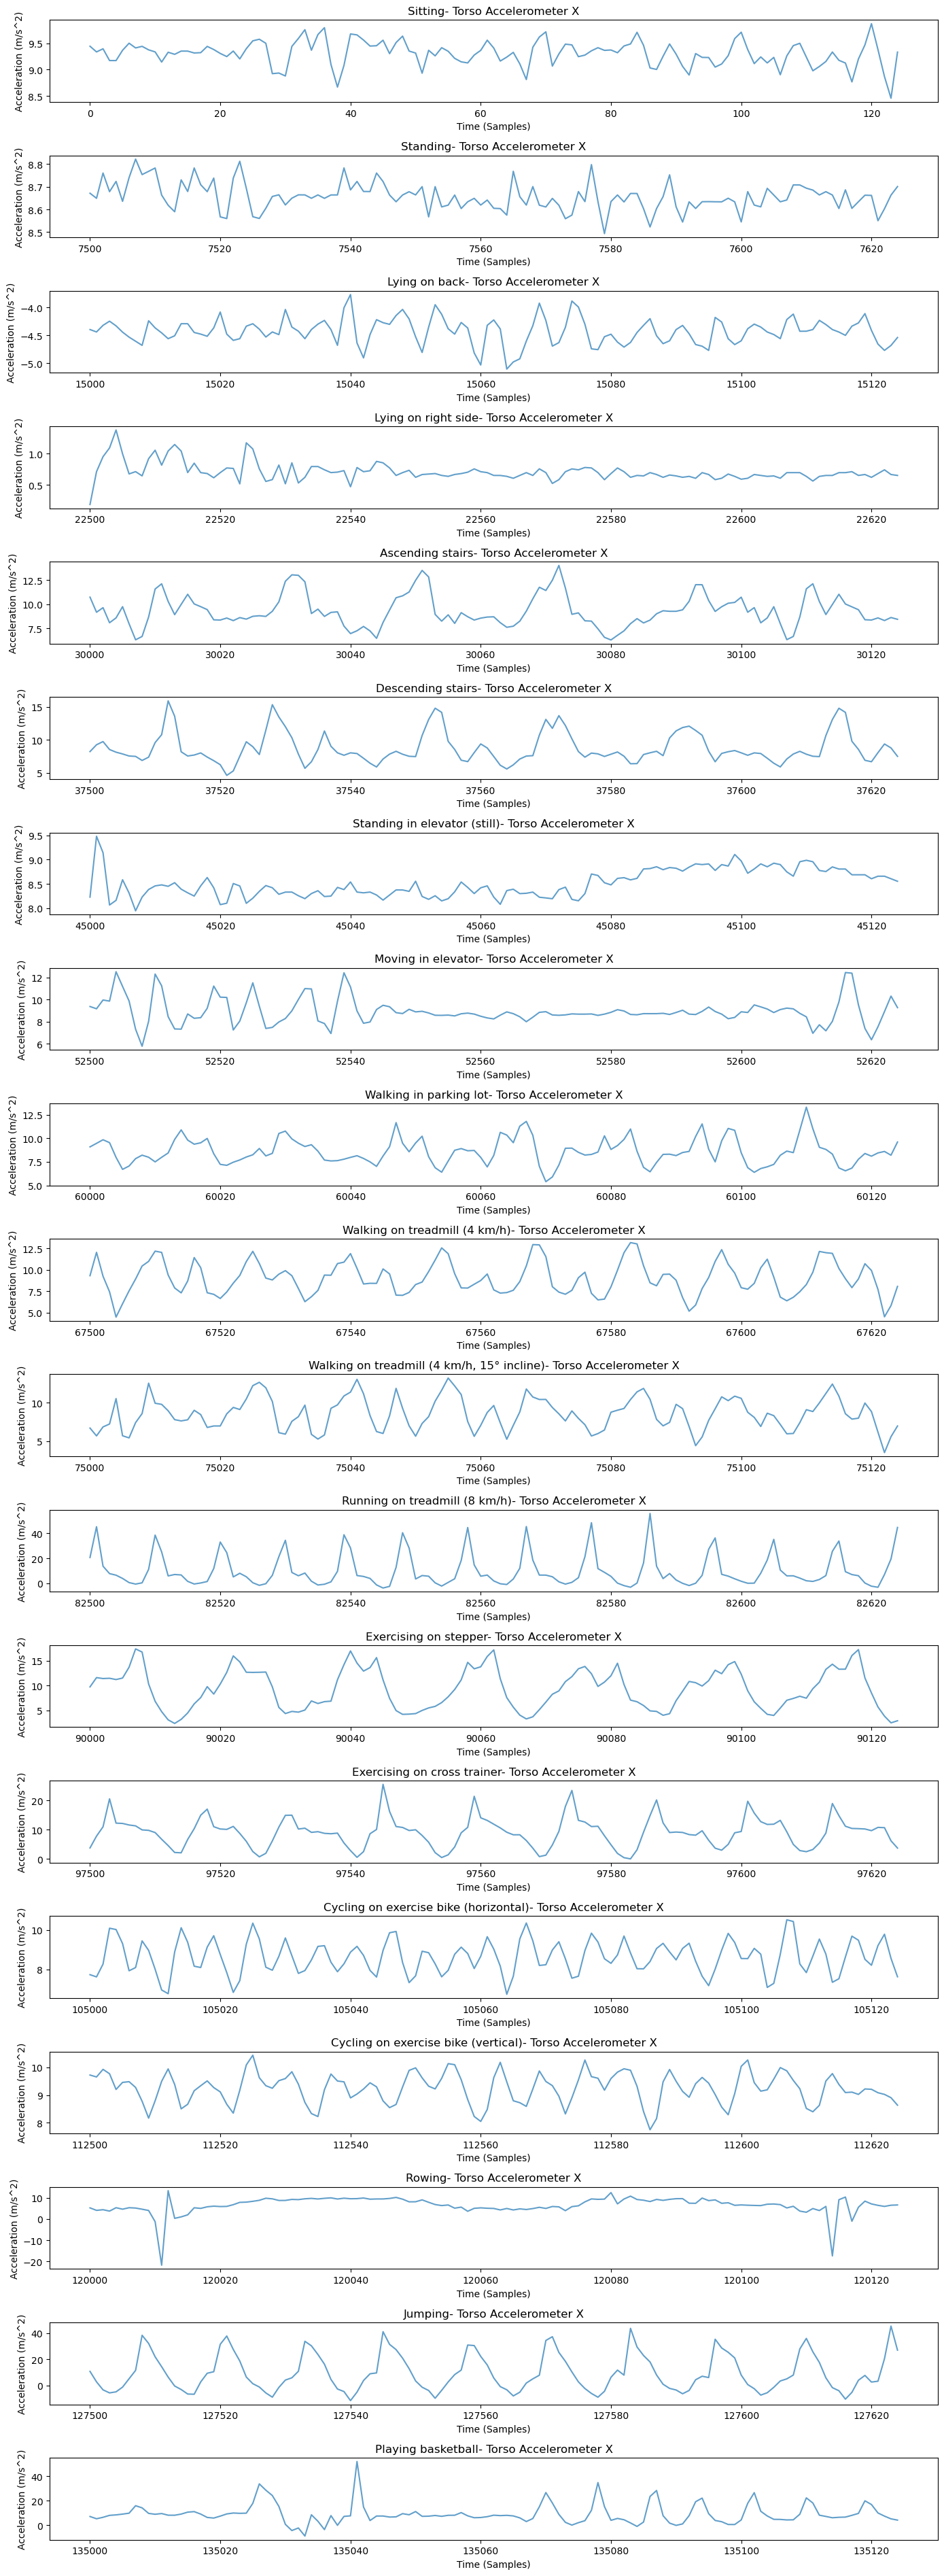

In [24]:
activity_names = {
    'a01': 'Sitting',
    'a02': 'Standing',
    'a03': 'Lying on back',
    'a04': 'Lying on right side',
    'a05': 'Ascending stairs',
    'a06': 'Descending stairs',
    'a07': 'Standing in elevator (still)',
    'a08': 'Moving in elevator',
    'a09': 'Walking in parking lot',
    'a10': 'Walking on treadmill (4 km/h)',
    'a11': 'Walking on treadmill (4 km/h, 15° incline)',
    'a12': 'Running on treadmill (8 km/h)',
    'a13': 'Exercising on stepper',
    'a14': 'Exercising on cross trainer',
    'a15': 'Cycling on exercise bike (horizontal)',
    'a16': 'Cycling on exercise bike (vertical)',
    'a17': 'Rowing',
    'a18': 'Jumping',
    'a19': 'Playing basketball'
}

num_activities = 19

fig, axes = plt.subplots(num_activities, 1, figsize=(14, 2 * num_activities))

for activity in range(1, 20):  
    activity_code = f'a{activity:02d}'  #generate the activity code (a01, a02, ..., a19)
    activity_name = activity_names[activity_code]

    #filter the data for the current activity
    activity_data = df_all_activities_p7[(df_all_activities_p7['Activity'] == activity_code) & 
                                       (df_all_activities_p7['Segment'] == 1)]

    # Plot the T_xacc data for this activity
    axes[activity - 1].plot(activity_data[0], label=f'Activity {activity:02d}', alpha=0.7)
    axes[activity - 1].set_title(f'{activity_name}- Torso Accelerometer X')
    axes[activity - 1].set_xlabel('Time (Samples)')
    axes[activity - 1].set_ylabel('Acceleration (m/s^2)')

plt.tight_layout()

plt.show() 


### Walking (flat) vs. Running

In [25]:
walking_flat = ['a10']

#filter the data for flat walking
df_flat_walk = df_all_activities_p7[df_all_activities_p7['Activity'].isin(walking_flat)]

df_flat_walk = df_flat_walk.drop(columns=['Activity'])
df_flat_walk = df_flat_walk.reset_index(drop=True)


df_flat_walk

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,Segment
0,9.3105,0.587000,-1.22880,-0.243650,-1.10660,0.037636,-0.72318,0.12456,-0.70206,5.0612,...,-9.8361,-0.18946,-1.565400,-0.407760,0.37506,1.13070,1.02110,0.36735,-0.165180,1
1,12.0460,-0.086358,0.52566,-0.179740,0.85106,0.270410,-0.72236,0.13881,-0.69857,5.3809,...,-9.1952,-2.43550,-0.948150,-0.036454,0.27783,0.87566,1.04600,0.34339,-0.189730,1
2,9.2470,-2.045200,10.73400,-1.551400,-0.60079,0.369790,-0.71560,0.16523,-0.70152,4.9954,...,-8.5541,0.87487,-2.190800,-0.636590,0.42847,0.99528,1.06150,0.33070,-0.197990,1
3,7.4230,-2.820000,2.47950,-0.806630,0.22937,0.226170,-0.71067,0.19402,-0.70193,4.9443,...,-9.1001,0.52867,-0.714470,-1.499400,0.35843,0.87873,1.07960,0.32330,-0.185960,1
4,4.4586,-1.529200,4.25580,0.330460,-0.11867,0.068550,-0.70185,0.20103,-0.70638,5.8938,...,-8.8194,-2.32180,0.223770,-0.307580,0.24665,0.94289,1.09740,0.31584,-0.167440,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,13.0260,-2.090000,3.41400,-0.733180,0.56922,-0.295890,-0.75816,0.22565,-0.67215,3.5181,...,-8.3513,-11.45300,-1.206700,-1.963200,-0.35229,-1.65000,1.12780,0.16460,-0.102240,60
7496,9.8045,-3.229600,2.15120,-0.465240,0.13433,-0.281310,-0.74811,0.22905,-0.68297,4.9081,...,-9.5351,-2.80570,-1.106300,-0.125010,0.16983,-3.20200,1.09900,0.24297,-0.071200,60
7497,6.8882,-3.021700,0.45185,-0.574540,-0.24699,-0.070430,-0.75187,0.23572,-0.68104,5.4628,...,-23.3450,4.16910,-3.420000,-1.758600,1.20250,-2.99880,1.05060,0.32943,-0.017143,60
7498,6.4846,-3.741100,-0.39146,0.319280,-0.69247,0.094932,-0.75965,0.23447,-0.66987,5.2400,...,-13.8020,2.70840,-0.035537,-1.513800,1.64410,-2.86410,0.98696,0.39303,0.103510,60


In [26]:
running = ['a12']

#filter the data for flat walking
df_run = df_all_activities_p7[df_all_activities_p7['Activity'].isin(running)]

df_run = df_run.drop(columns=['Activity'])
df_run = df_run.reset_index(drop=True)

df_run

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,Segment
0,20.6030,-1.37780,8.62010,1.89800,0.26148,-0.30337,-0.90140,0.212530,-0.57884,2.9180,...,-23.9930,-0.36275,5.10250,-0.29726,1.074700,-3.33850,0.95984,0.41179,0.099259,1
1,45.3020,-6.08260,5.55390,2.16870,-2.55130,1.55800,-0.99409,0.132640,-0.46885,5.7983,...,-24.3200,7.54730,1.39820,0.21072,0.795750,-3.93880,0.86717,0.52657,0.160060,1
2,13.6200,3.49220,-0.39839,3.38710,4.34650,-0.35181,-0.96845,0.115660,-0.50603,2.8863,...,-15.1510,7.86050,2.10670,-0.22140,0.854630,-3.30470,0.75126,0.63382,0.205570,1
3,7.6722,-0.92661,6.94340,1.98230,-0.21781,-0.52051,-0.91089,0.050433,-0.58311,5.3755,...,-10.7170,6.52490,4.29950,0.30123,0.528250,-1.05610,0.69343,0.68394,0.195210,1
4,6.4156,-2.28970,0.18084,-0.93262,0.60615,0.46005,-0.87487,0.039289,-0.60690,4.8349,...,-2.4467,13.19200,0.63253,4.97850,0.131000,0.59898,0.69825,0.70404,0.078655,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,-3.1025,5.65030,-3.23360,-1.27080,-1.83460,-0.90296,-0.78864,-0.001589,-0.65606,3.8507,...,-3.5330,-10.73200,4.00150,2.21070,-0.301190,-0.20013,0.89038,0.63903,-0.111490,60
7496,-3.6930,3.84300,-5.84620,-1.75420,-2.79180,-1.64210,-0.84638,-0.002098,-0.57030,3.9235,...,-35.7560,-29.58100,-9.80130,1.08140,3.651500,-1.24390,0.90530,0.61314,-0.060199,60
7497,14.6930,5.90460,-17.40700,2.96150,-1.21430,1.23160,-0.95927,0.023008,-0.39422,5.5976,...,-8.4985,33.08800,-2.32150,-1.41340,-0.061114,1.38910,0.90174,0.62971,-0.011861,60
7498,66.6420,14.74700,75.97500,3.92580,0.59224,-0.68810,-0.97238,-0.032524,-0.44721,3.4161,...,-30.8760,-22.29300,5.86900,-0.67024,-1.390700,5.76130,1.00840,0.50869,0.019592,60


### Selecting one segment

In [27]:
df_flat_walk = df_flat_walk[df_flat_walk['Segment'] == 1]
df_flat_walk.drop(columns=['Segment'], inplace=True)

df_run = df_run[df_run['Segment'] == 1]
df_run.drop(columns=['Segment'], inplace=True)

/var/folders/ph/hryvf5m94jx0bs4j7nxpwrfr0000gn/T/ipykernel_4796/226331727.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flat_walk.drop(columns=['Segment'], inplace=True)
/var/folders/ph/hryvf5m94jx0bs4j7nxpwrfr0000gn/T/ipykernel_4796/226331727.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_run.drop(columns=['Segment'], inplace=True)


I compared the torso, right arm, and right leg to compare walking versus running and visualized data measured from the x, y, and z-axis accelerometer, gyroscope, and magnetometer for each of the aforementoined body parts.

### Torso X

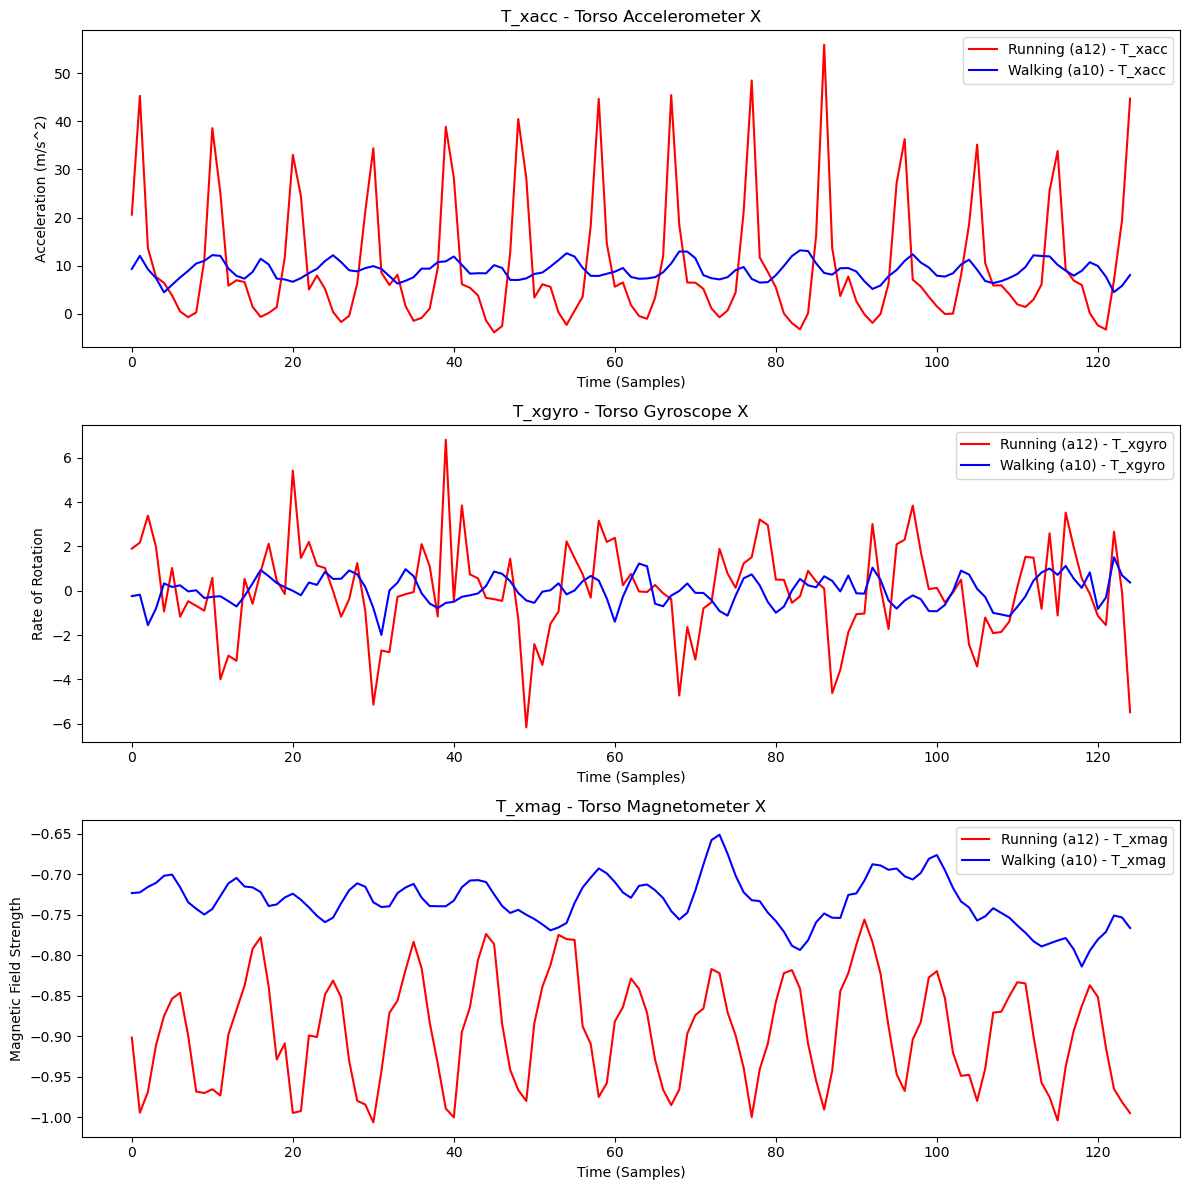

In [28]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots (one for each accelerometer: T_xacc, RA_xacc, RL_xacc)
fig, axes = plt.subplots(3, 1, figsize=(12, 12))  # 3 rows, 1 column

#torso accelerometer
axes[0].plot(df_run[0], label='Running (a12) - T_xacc', color='r')
axes[0].plot(df_flat_walk[0], label='Walking (a10) - T_xacc', color='b')
axes[0].set_title('T_xacc - Torso Accelerometer X')
axes[0].set_xlabel('Time (Samples)')
axes[0].set_ylabel('Acceleration (m/s^2)')
axes[0].legend()

#torso gyroscope
axes[1].plot(df_run[3], label='Running (a12) - T_xgyro', color='r')
axes[1].plot(df_flat_walk[3], label='Walking (a10) - T_xgyro', color='b')
axes[1].set_title('T_xgyro - Torso Gyroscope X')
axes[1].set_xlabel('Time (Samples)')
axes[1].set_ylabel('Rate of Rotation')
axes[1].legend()

#torso magnometer
axes[2].plot(df_run[6], label='Running (a12) - T_xmag', color='r')
axes[2].plot(df_flat_walk[6], label='Walking (a10) - T_xmag', color='b')
axes[2].set_title('T_xmag - Torso Magnetometer X')
axes[2].set_xlabel('Time (Samples)')
axes[2].set_ylabel('Magnetic Field Strength')
axes[2].legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


### Torso Y

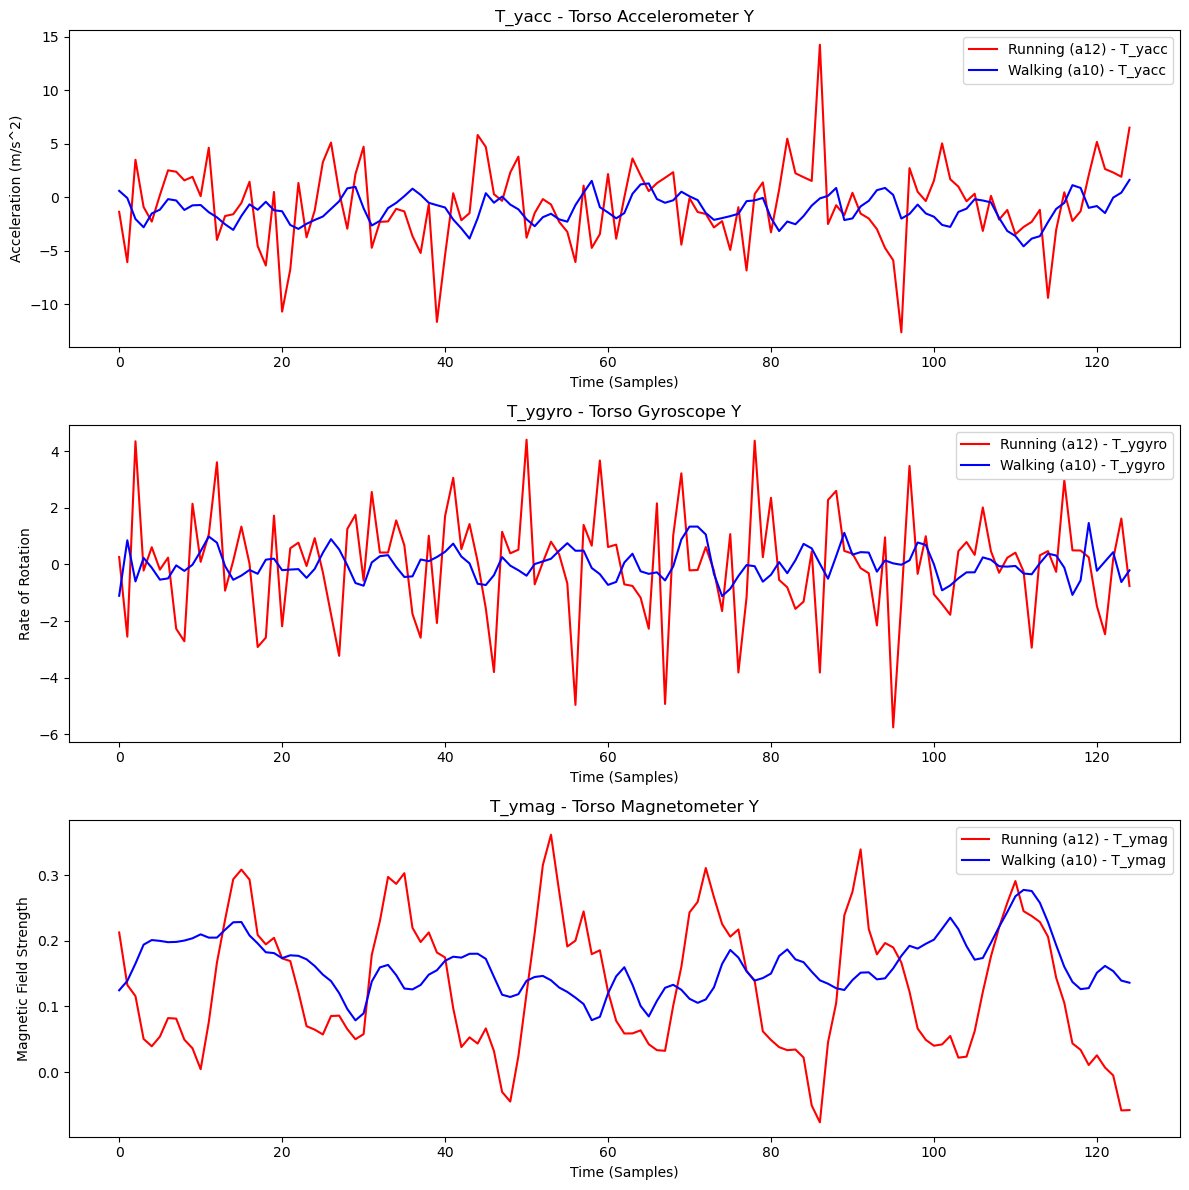

In [29]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots (one for each accelerometer: T_xacc, RA_xacc, RL_xacc)
fig, axes = plt.subplots(3, 1, figsize=(12, 12))  # 3 rows, 1 column

#torso accelerometer
axes[0].plot(df_run[1], label='Running (a12) - T_yacc', color='r')
axes[0].plot(df_flat_walk[1], label='Walking (a10) - T_yacc', color='b')
axes[0].set_title('T_yacc - Torso Accelerometer Y')
axes[0].set_xlabel('Time (Samples)')
axes[0].set_ylabel('Acceleration (m/s^2)')
axes[0].legend()

#torso gyroscope
axes[1].plot(df_run[4], label='Running (a12) - T_ygyro', color='r')
axes[1].plot(df_flat_walk[4], label='Walking (a10) - T_ygyro', color='b')
axes[1].set_title('T_ygyro - Torso Gyroscope Y')
axes[1].set_xlabel('Time (Samples)')
axes[1].set_ylabel('Rate of Rotation')
axes[1].legend()

#torso magnometer
axes[2].plot(df_run[7], label='Running (a12) - T_ymag', color='r')
axes[2].plot(df_flat_walk[7], label='Walking (a10) - T_ymag', color='b')
axes[2].set_title('T_ymag - Torso Magnetometer Y')
axes[2].set_xlabel('Time (Samples)')
axes[2].set_ylabel('Magnetic Field Strength')
axes[2].legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


### Torso Z

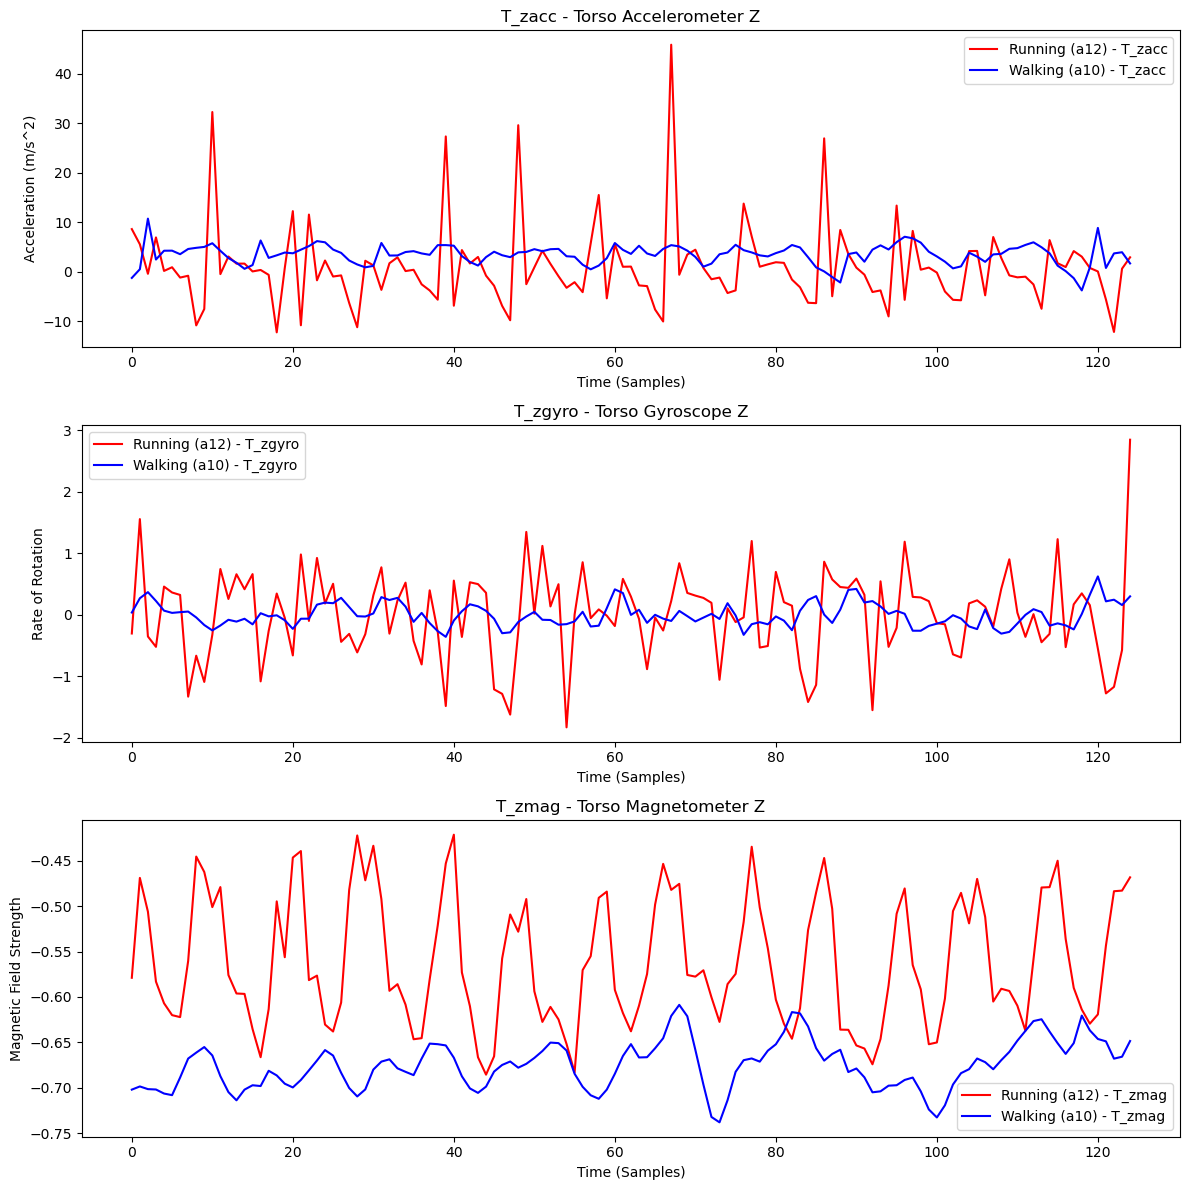

In [30]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots (one for each accelerometer: T_xacc, RA_xacc, RL_xacc)
fig, axes = plt.subplots(3, 1, figsize=(12, 12))  # 3 rows, 1 column

#torso accelerometer
axes[0].plot(df_run[2], label='Running (a12) - T_zacc', color='r')
axes[0].plot(df_flat_walk[2], label='Walking (a10) - T_zacc', color='b')
axes[0].set_title('T_zacc - Torso Accelerometer Z')
axes[0].set_xlabel('Time (Samples)')
axes[0].set_ylabel('Acceleration (m/s^2)')
axes[0].legend()

#torso gyroscope
axes[1].plot(df_run[5], label='Running (a12) - T_zgyro', color='r')
axes[1].plot(df_flat_walk[5], label='Walking (a10) - T_zgyro', color='b')
axes[1].set_title('T_zgyro - Torso Gyroscope Z')
axes[1].set_xlabel('Time (Samples)')
axes[1].set_ylabel('Rate of Rotation')
axes[1].legend()

#torso magnometer
axes[2].plot(df_run[8], label='Running (a12) - T_zmag', color='r')
axes[2].plot(df_flat_walk[8], label='Walking (a10) - T_zmag', color='b')
axes[2].set_title('T_zmag - Torso Magnetometer Z')
axes[2].set_xlabel('Time (Samples)')
axes[2].set_ylabel('Magnetic Field Strength')
axes[2].legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


Overall, the range of movement of the torso when running in comparison to walking was much larger. I also see more of a clear pattern in torso movement when running compared to walking, which makes sense when I imagine someone running at a steady pace so their body moves more or less in the same way at each stride. Walking has maybe less range of movement but more possibility for variation and breaking patterns because of less focus on maintaining a strenuous action, like running

### Right arm X

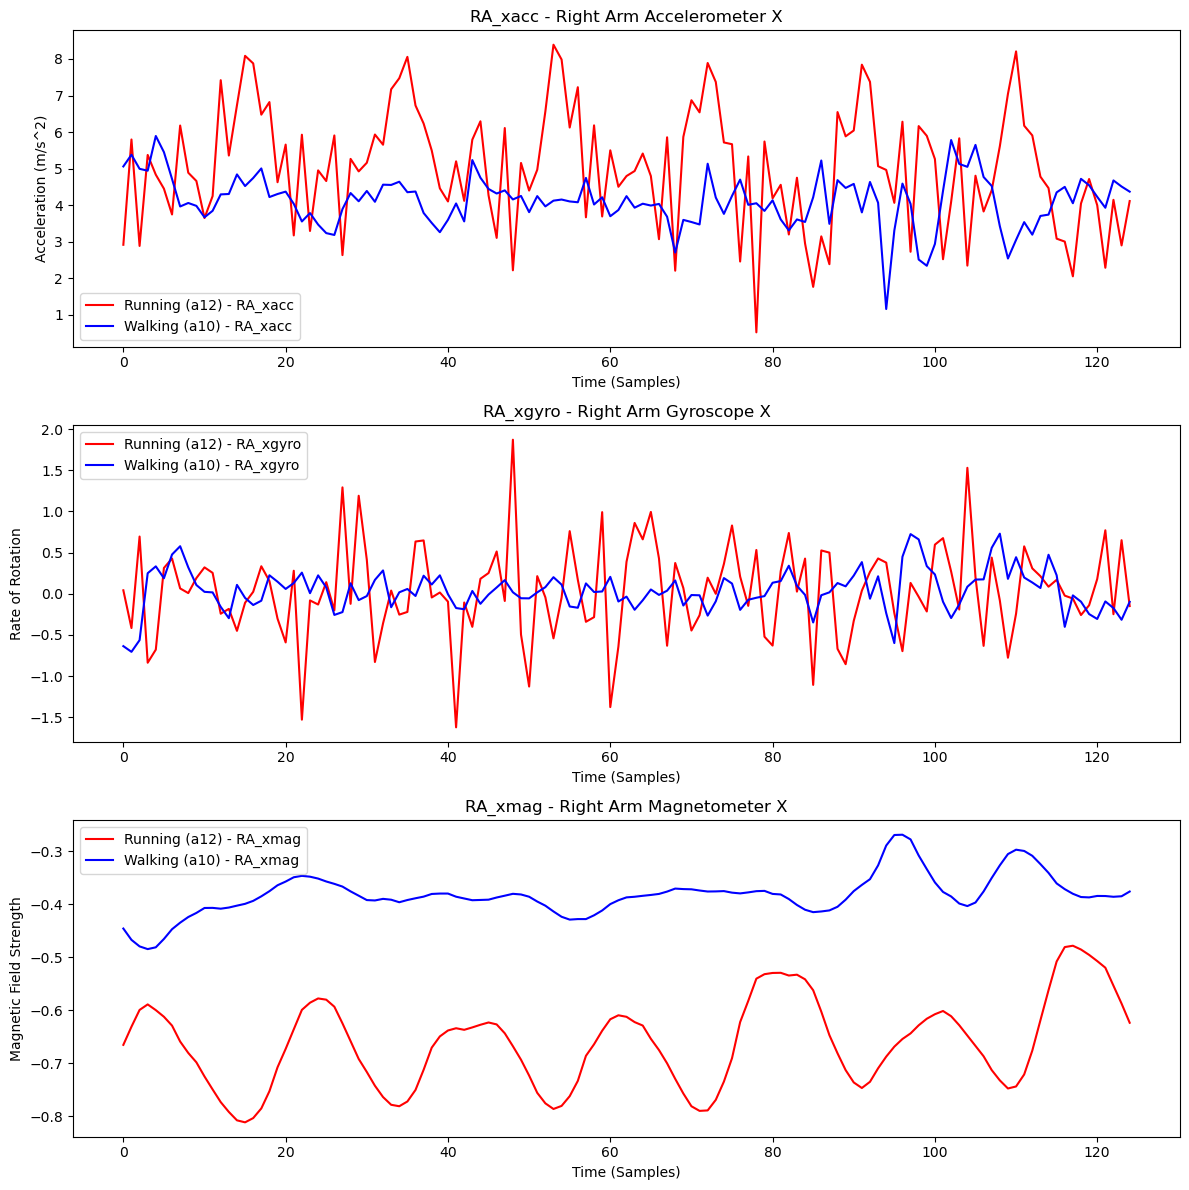

In [31]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots (one for each accelerometer: T_xacc, RA_xacc, RL_xacc)
fig, axes = plt.subplots(3, 1, figsize=(12, 12))  # 3 rows, 1 column

#right arm accelerometer
axes[0].plot(df_run[9], label='Running (a12) - RA_xacc', color='r')
axes[0].plot(df_flat_walk[9], label='Walking (a10) - RA_xacc', color='b')
axes[0].set_title('RA_xacc - Right Arm Accelerometer X')
axes[0].set_xlabel('Time (Samples)')
axes[0].set_ylabel('Acceleration (m/s^2)')
axes[0].legend()

#right arm gyroscope
axes[1].plot(df_run[12], label='Running (a12) - RA_xgyro', color='r')
axes[1].plot(df_flat_walk[12], label='Walking (a10) - RA_xgyro', color='b')
axes[1].set_title('RA_xgyro - Right Arm Gyroscope X')
axes[1].set_xlabel('Time (Samples)')
axes[1].set_ylabel('Rate of Rotation')
axes[1].legend()

#right arm magnometer
axes[2].plot(df_run[15], label='Running (a12) - RA_xmag', color='r')
axes[2].plot(df_flat_walk[15], label='Walking (a10) - RA_xmag', color='b')
axes[2].set_title('RA_xmag - Right Arm Magnetometer X')
axes[2].set_xlabel('Time (Samples)')
axes[2].set_ylabel('Magnetic Field Strength')
axes[2].legend()


# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


### Right arm Y

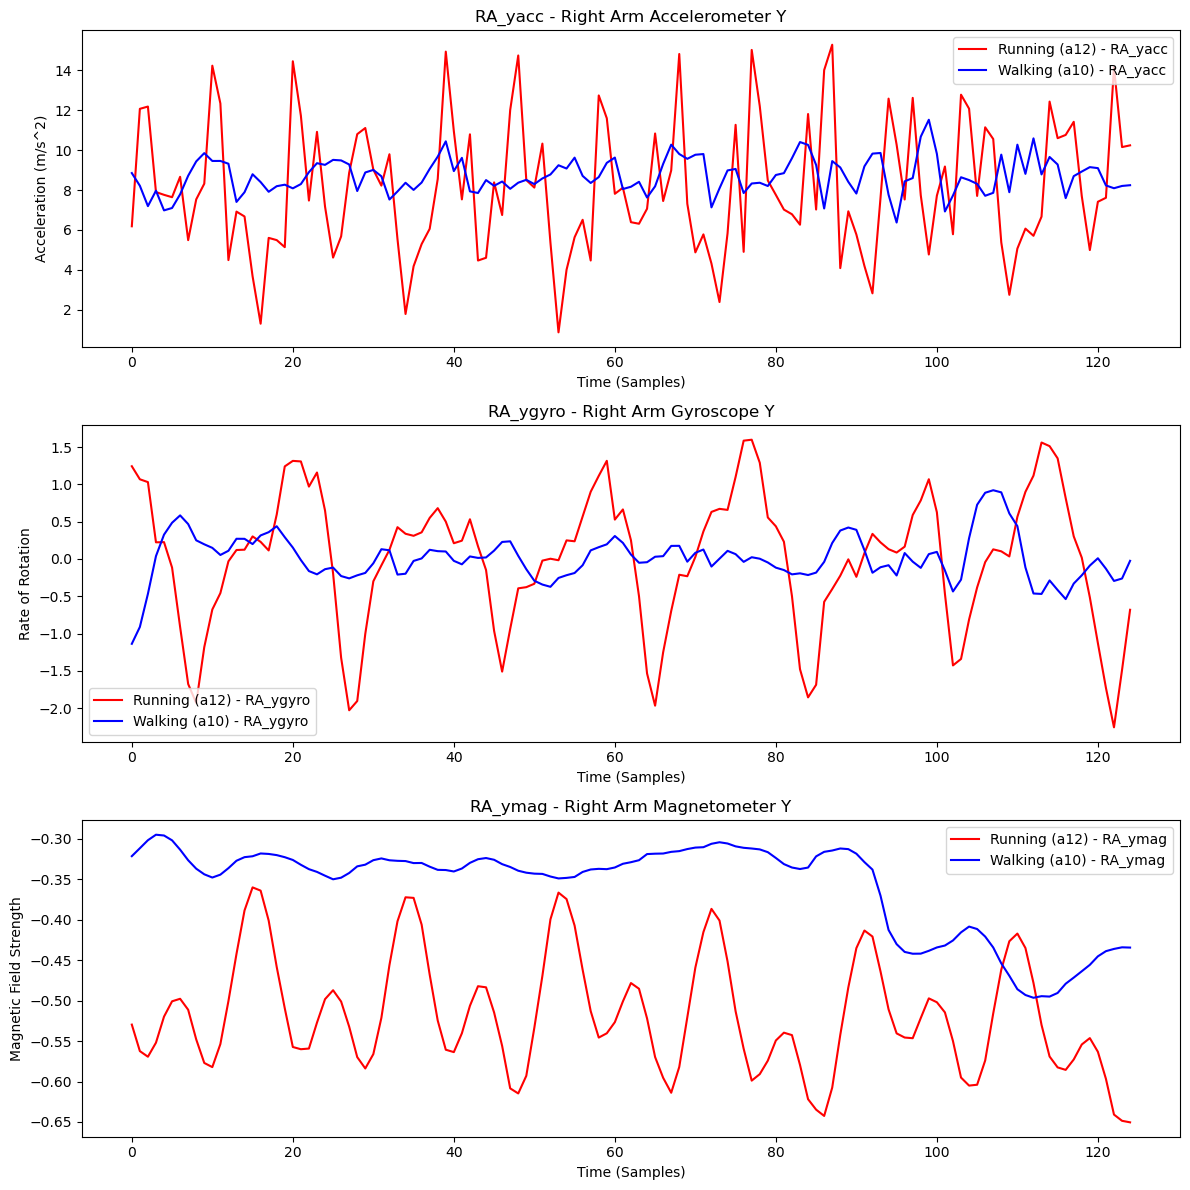

In [32]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots (one for each accelerometer: T_xacc, RA_xacc, RL_xacc)
fig, axes = plt.subplots(3, 1, figsize=(12, 12))  # 3 rows, 1 column

#right arm accelerometer
axes[0].plot(df_run[10], label='Running (a12) - RA_yacc', color='r')
axes[0].plot(df_flat_walk[10], label='Walking (a10) - RA_yacc', color='b')
axes[0].set_title('RA_yacc - Right Arm Accelerometer Y')
axes[0].set_xlabel('Time (Samples)')
axes[0].set_ylabel('Acceleration (m/s^2)')
axes[0].legend()

#right arm gyroscope
axes[1].plot(df_run[13], label='Running (a12) - RA_ygyro', color='r')
axes[1].plot(df_flat_walk[13], label='Walking (a10) - RA_ygyro', color='b')
axes[1].set_title('RA_ygyro - Right Arm Gyroscope Y')
axes[1].set_xlabel('Time (Samples)')
axes[1].set_ylabel('Rate of Rotation')
axes[1].legend()

#right arm magnometer
axes[2].plot(df_run[16], label='Running (a12) - RA_ymag', color='r')
axes[2].plot(df_flat_walk[16], label='Walking (a10) - RA_ymag', color='b')
axes[2].set_title('RA_ymag - Right Arm Magnetometer Y')
axes[2].set_xlabel('Time (Samples)')
axes[2].set_ylabel('Magnetic Field Strength')
axes[2].legend()


# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


### Right arm Z

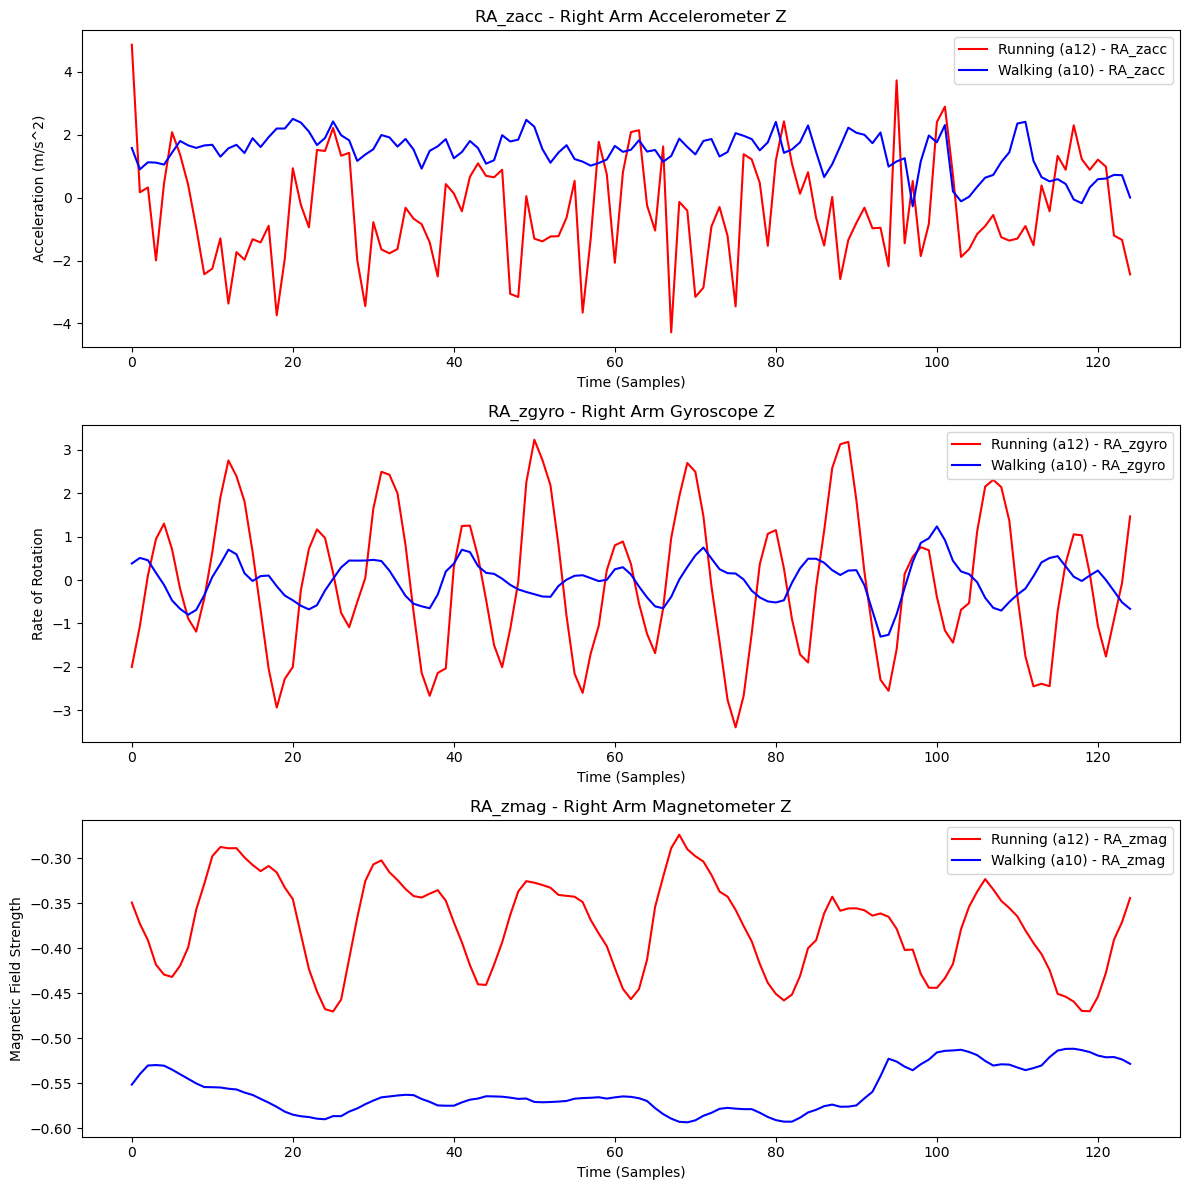

In [33]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots (one for each accelerometer: T_xacc, RA_xacc, RL_xacc)
fig, axes = plt.subplots(3, 1, figsize=(12, 12))  # 3 rows, 1 column

#right arm accelerometer
axes[0].plot(df_run[11], label='Running (a12) - RA_zacc', color='r')
axes[0].plot(df_flat_walk[11], label='Walking (a10) - RA_zacc', color='b')
axes[0].set_title('RA_zacc - Right Arm Accelerometer Z')
axes[0].set_xlabel('Time (Samples)')
axes[0].set_ylabel('Acceleration (m/s^2)')
axes[0].legend()

#right arm gyroscope
axes[1].plot(df_run[14], label='Running (a12) - RA_zgyro', color='r')
axes[1].plot(df_flat_walk[14], label='Walking (a10) - RA_zgyro', color='b')
axes[1].set_title('RA_zgyro - Right Arm Gyroscope Z')
axes[1].set_xlabel('Time (Samples)')
axes[1].set_ylabel('Rate of Rotation')
axes[1].legend()

#right arm magnometer
axes[2].plot(df_run[17], label='Running (a12) - RA_zmag', color='r')
axes[2].plot(df_flat_walk[17], label='Walking (a10) - RA_zmag', color='b')
axes[2].set_title('RA_zmag - Right Arm Magnetometer Z')
axes[2].set_xlabel('Time (Samples)')
axes[2].set_ylabel('Magnetic Field Strength')
axes[2].legend()


# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


Once again, the right arm moves less while running than while walking, although at the end of the segment I visualized, maybe the arm started working a little bit harder during the walk, like maybe person 7 started pumping their arm more. Still, the right arm during the run was more consistently active and covered a wider range of motion.

### Right leg X

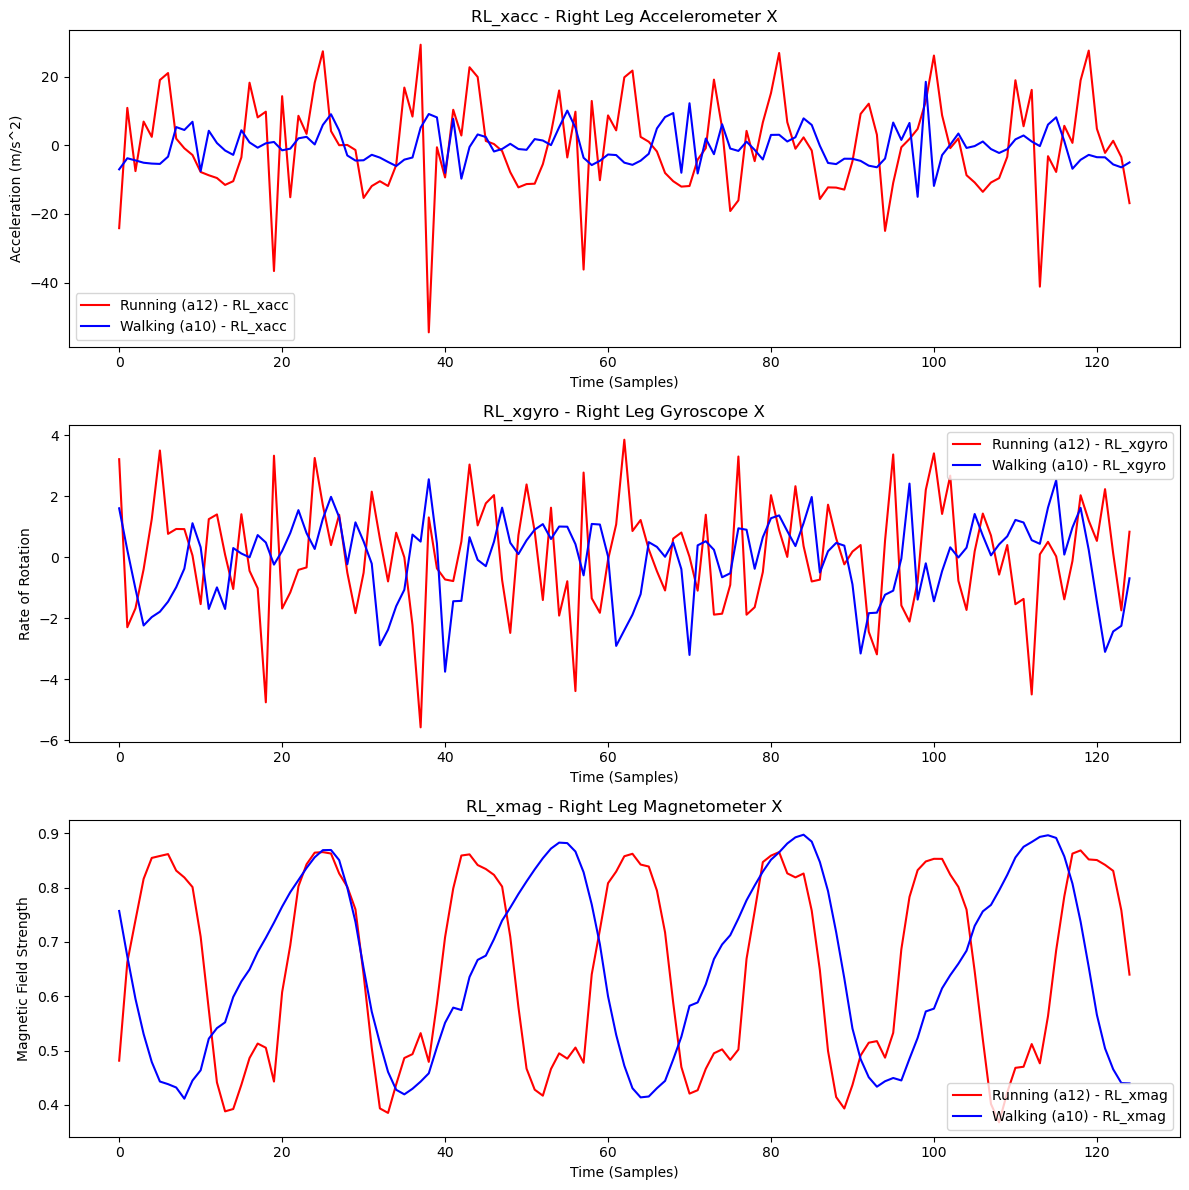

In [34]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots (one for each accelerometer: T_xacc, RA_xacc, RL_xacc)
fig, axes = plt.subplots(3, 1, figsize=(12, 12))  # 3 rows, 1 column


#right leg accelerometer
axes[0].plot(df_run[28], label='Running (a12) - RL_xacc', color='r')
axes[0].plot(df_flat_walk[28], label='Walking (a10) - RL_xacc', color='b')
axes[0].set_title('RL_xacc - Right Leg Accelerometer X')
axes[0].set_xlabel('Time (Samples)')
axes[0].set_ylabel('Acceleration (m/s^2)')
axes[0].legend()

#right leg gyroscope
axes[1].plot(df_run[30], label='Running (a12) - RL_xgyro', color='r')
axes[1].plot(df_flat_walk[30], label='Walking (a10) - RL_xgyro', color='b')
axes[1].set_title('RL_xgyro - Right Leg Gyroscope X')
axes[1].set_xlabel('Time (Samples)')
axes[1].set_ylabel('Rate of Rotation')
axes[1].legend()

# right let magnometer
axes[2].plot(df_run[33], label='Running (a12) - RL_xmag', color='r')
axes[2].plot(df_flat_walk[33], label='Walking (a10) - RL_xmag', color='b')
axes[2].set_title('RL_xmag - Right Leg Magnetometer X')
axes[2].set_xlabel('Time (Samples)')
axes[2].set_ylabel('Magnetic Field Strength')
axes[2].legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show() 


### Right Leg Y

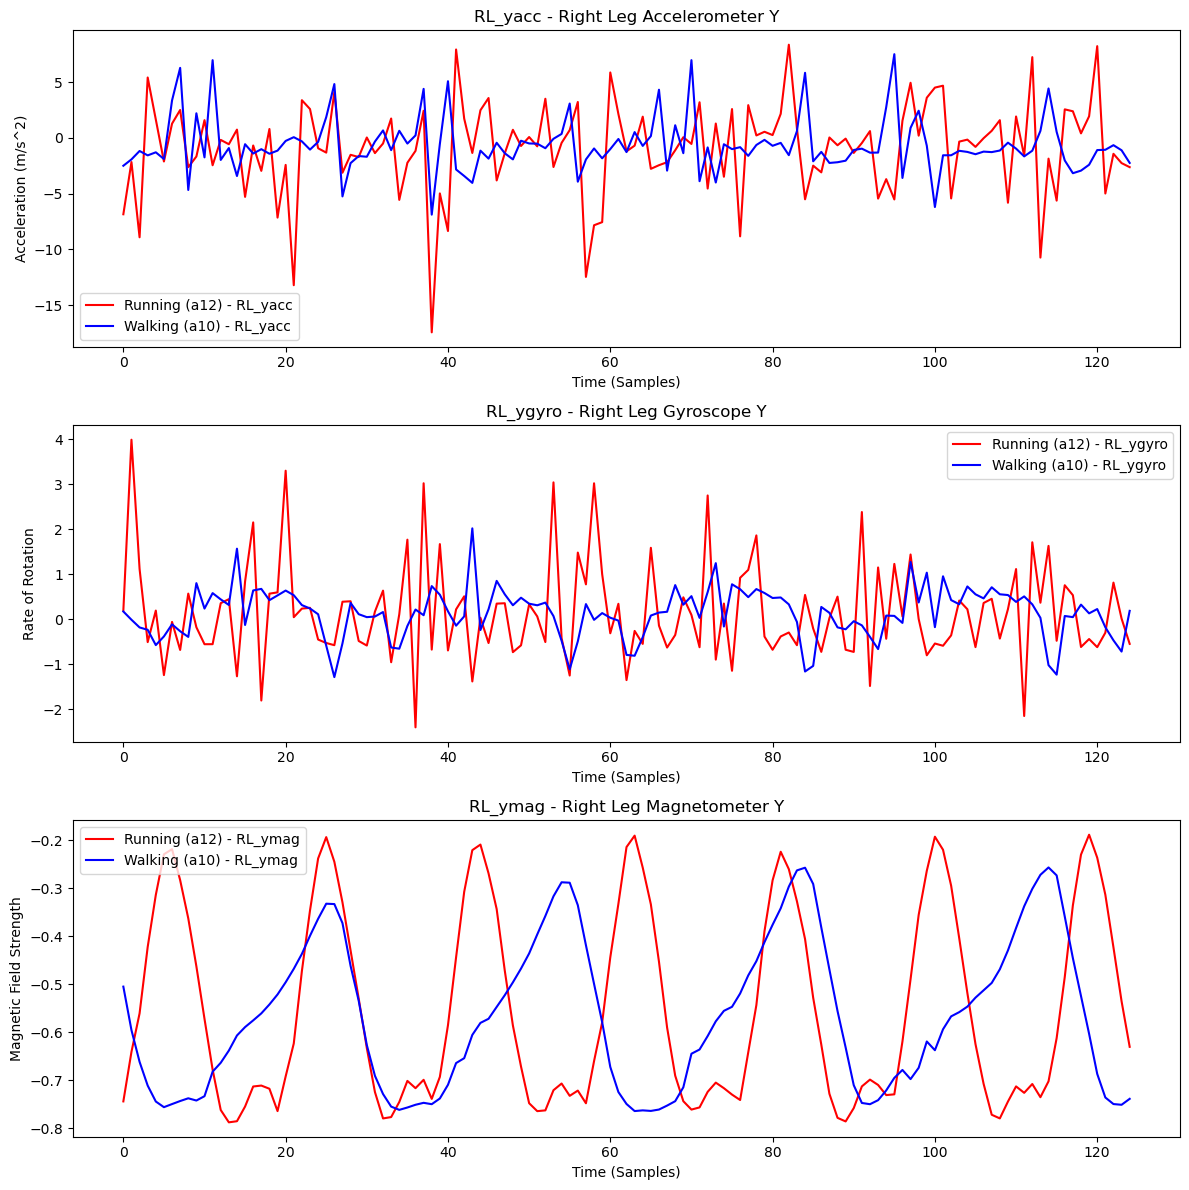

In [35]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots (one for each accelerometer: T_xacc, RA_xacc, RL_xacc)
fig, axes = plt.subplots(3, 1, figsize=(12, 12))  # 3 rows, 1 column


#right leg accelerometer
axes[0].plot(df_run[29], label='Running (a12) - RL_yacc', color='r')
axes[0].plot(df_flat_walk[29], label='Walking (a10) - RL_yacc', color='b')
axes[0].set_title('RL_yacc - Right Leg Accelerometer Y')
axes[0].set_xlabel('Time (Samples)')
axes[0].set_ylabel('Acceleration (m/s^2)')
axes[0].legend()

#right leg gyroscope
axes[1].plot(df_run[31], label='Running (a12) - RL_ygyro', color='r')
axes[1].plot(df_flat_walk[31], label='Walking (a10) - RL_ygyro', color='b')
axes[1].set_title('RL_ygyro - Right Leg Gyroscope Y')
axes[1].set_xlabel('Time (Samples)')
axes[1].set_ylabel('Rate of Rotation')
axes[1].legend()

# right let magnometer
axes[2].plot(df_run[34], label='Running (a12) - RL_ymag', color='r')
axes[2].plot(df_flat_walk[34], label='Walking (a10) - RL_ymag', color='b')
axes[2].set_title('RL_ymag - Right Leg Magnetometer Y')
axes[2].set_xlabel('Time (Samples)')
axes[2].set_ylabel('Magnetic Field Strength')
axes[2].legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show() 


### Right Leg Z

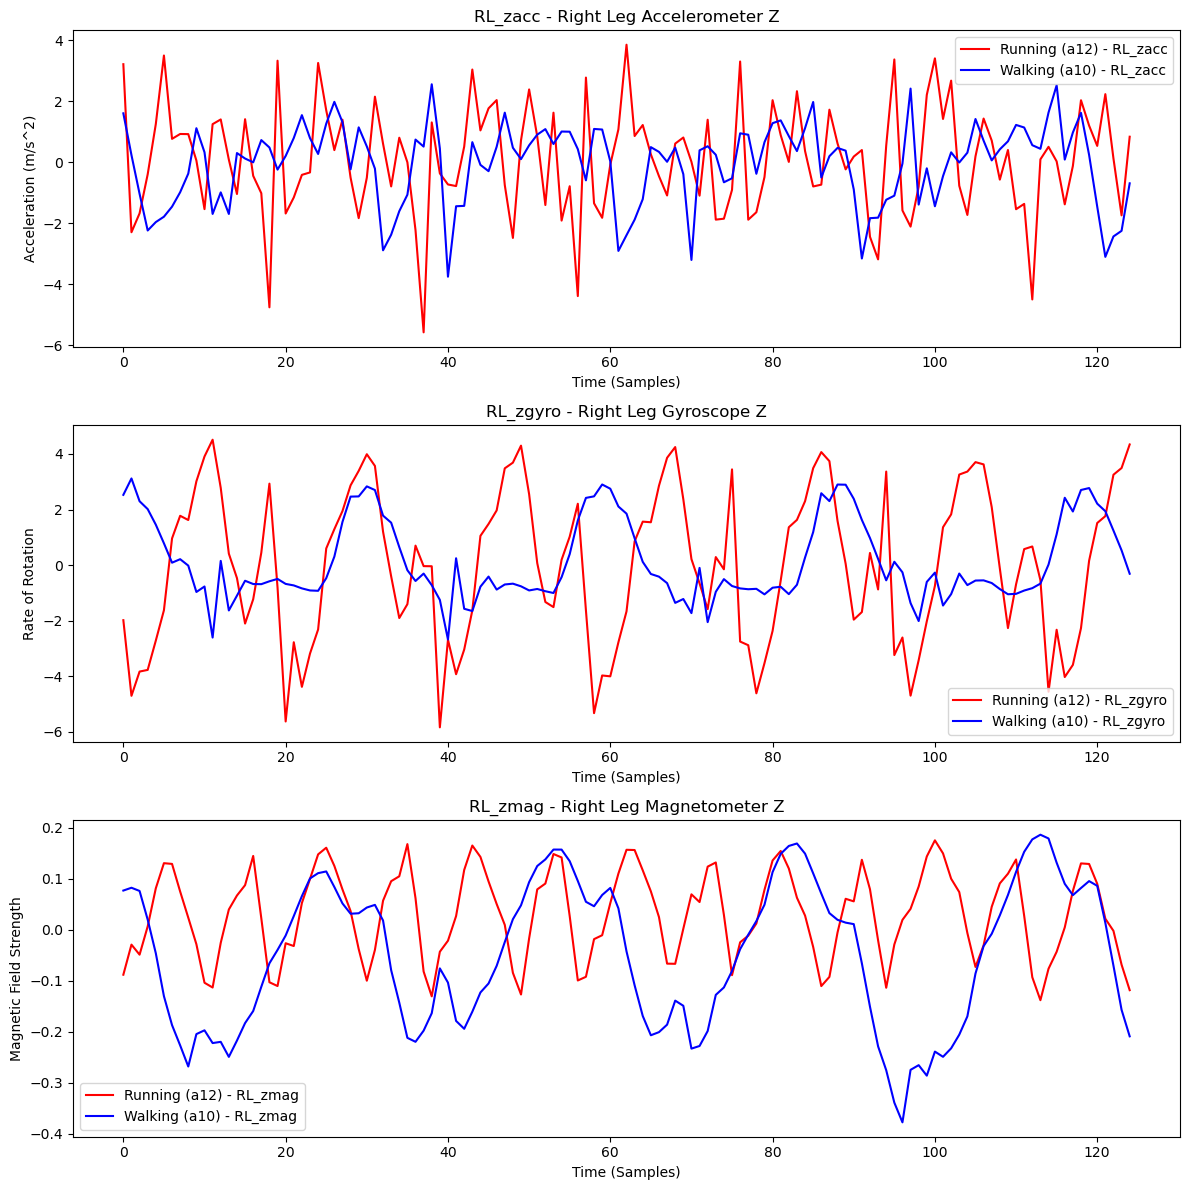

In [56]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots (one for each accelerometer: T_xacc, RA_xacc, RL_xacc)
fig, axes = plt.subplots(3, 1, figsize=(12, 12))  # 3 rows, 1 column


#right leg accelerometer
axes[0].plot(df_run[30], label='Running (a12) - RL_zacc', color='r')
axes[0].plot(df_flat_walk[30], label='Walking (a10) - RL_zacc', color='b')
axes[0].set_title('RL_zacc - Right Leg Accelerometer Z')
axes[0].set_xlabel('Time (Samples)')
axes[0].set_ylabel('Acceleration (m/s^2)')
axes[0].legend()

#right leg gyroscope
axes[1].plot(df_run[32], label='Running (a12) - RL_zgyro', color='r')
axes[1].plot(df_flat_walk[32], label='Walking (a10) - RL_zgyro', color='b')
axes[1].set_title('RL_zgyro - Right Leg Gyroscope Z')
axes[1].set_xlabel('Time (Samples)')
axes[1].set_ylabel('Rate of Rotation')
axes[1].legend()

# right let magnometer
axes[2].plot(df_run[35], label='Running (a12) - RL_zmag', color='r')
axes[2].plot(df_flat_walk[35], label='Walking (a10) - RL_zmag', color='b')
axes[2].set_title('RL_zmag - Right Leg Magnetometer Z')
axes[2].set_xlabel('Time (Samples)')
axes[2].set_ylabel('Magnetic Field Strength')
axes[2].legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show() 


The right leg's range of motion seems to be a bit more comparable between running and walking, especially in the measurements taken by the magnetometer, the graphs are very similar. This makes sense to me becuase,although when running the leg maybe moves harder, walking is still very reliant on leg movement.

## Exercise 2

Build a model (classifier) to predict the activity of a given subject. Decide on which features could be extracted from the data. For example:

- **mean, variance,skewness, and the kurtosis**. The distribution of each signal are approximately Normal. This means that we can take the first four statistical moments for each 5 second segment. By including the four moments, we are helping our models better learn the characteristic of each unique activity. 
- n first values of the  the  [**autocorrelation**](https://en.wikipedia.org/wiki/Autocorrelation) sequence. In some time series analyses, such as in [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average), it is desirable to minimize autocorrelation so as to transform the series into a [stationary state](https://en.wikipedia.org/wiki/Stationary_process). 
- n peaks of the [**discrete Fourier transform**](https://en.wikipedia.org/wiki/Discrete_Fourier_transform)
of a segment with the corresponding frequencies.

Consider normalising all features between [0,1] and reduce the dimension of features using [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis).


We propose 2 approaches to create your train/testing set.

(1) Train and test sets that contain shuffled samples from each user. So the model will train on data from every user and predict the activities from every user in the test set.
(2) Seven user's data will be used as the training set and only one user's data as the test set. The goal here is to predict the activities of a user that the model has never seen before. How good is the model generalising the problem?

For each approach, consider the following building framework:
1. Split data into train and holdout sets
2. Optimize model hyperparameters
3. Cross Validate model's performance by analyze learning curves

Finally, consider the follwing evaluation metrics:

**Accuracy** represents how close or far off a given set of measurements are to their true value.

**Precision**: percentage of classifications predicted to be positive are actually positive. **Precision is a measure of the failure to correctly predict positive classifications. **

$$\textbf{Precision} = \frac{TP}{TP + FP}, $$

where TP refers to True Positives and FP to False Positives. 

**Recall** describes how well the model can identify points that belong to the positive class. **Recall is a measure of the failure in distinguishing between positive and negative classifications. **

$$\textbf{Recall} = \frac{TP}{TP + FN},$$

where FN corresponds to False Negatives.

Finally, the $f_{1} score$ is a weighted average of precision and recall. The  $f_{1} score$  is used to get a measure of both types of failures.

**Note: Make comments on the code to discuss the results.**
 

### Feature extraction on only p7
Making sure it works

In [7]:
from scipy.stats import skew, kurtosis

def extract_features(data):
    #print(f"Input data has {data.shape[1]} columns")

    agg_funcs = {
        'mean': 'mean',
        'variance': 'var',
        'skewness': skew,
        'kurtosis': kurtosis
    }

    features = []

    for func_name, func in agg_funcs.items():
        aggregated = data.aggregate(func, axis=0)
        features.append(aggregated)

    # Concatenate all features into a single array
    return np.concatenate([f.values for f in features])


def normalize_data(X):
    scaler = MinMaxScaler()
    return scaler.fit_transform(X)

def apply_pca(X, n_components=50):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(X)

In [48]:
# Extract features and labels
X_p7 = []
y_p7 = []

for activity in df_all_activities_p7['Activity'].unique():
    activity_data = df_all_activities_p7[df_all_activities_p7['Activity'] == activity]
    for segment in activity_data['Segment'].unique():
        segment_data = activity_data[activity_data['Segment'] == segment]
        segment_data_numeric = segment_data.drop(columns=['Activity', 'Segment'])
        #print(segment_data)
        features = extract_features(segment_data_numeric)
        X_p7.append(features)
        y_p7.append(activity)


In [49]:
column_names = []
for axis in range(0, 45):  # 45 sensors
    column_names.append(f'segment_{axis}_mean')
    column_names.append(f'segment_{axis}_variance')
    column_names.append(f'segment_{axis}_skewness')
    column_names.append(f'segment_{axis}_kurtosis')

X_p7 = pd.DataFrame(X_p7, columns=[f'feature_{i}' for i in range(len(X_p7[0]))])

num_rows = len(X_p7)
num_chunks = num_rows // 60  # Number of full chunks of 60 rows

# Reshape the data so that each 60 rows become a single row
X_reshaped = X_p7.values[:num_chunks * 60].reshape(num_chunks, 60 * X_p7.shape[1])

reshaped_column_names = []
for i in range(60):  # 60 rows per chunk
    for name in column_names:
        reshaped_column_names.append(f'{name}_row_{i}')

# Convert the reshaped data back into a DataFrame
X_p7 = pd.DataFrame(X_reshaped, columns=[f'feature_{i}' for i in range(X_reshaped.shape[1])])
X_p7.columns = reshaped_column_names

X_p7

,segment_0_mean_row_0,segment_0_variance_row_0,segment_0_skewness_row_0,segment_0_kurtosis_row_0,segment_1_mean_row_0,segment_1_variance_row_0,segment_1_skewness_row_0,segment_1_kurtosis_row_0,segment_2_mean_row_0,segment_2_variance_row_0,...,segment_42_skewness_row_59,segment_42_kurtosis_row_59,segment_43_mean_row_59,segment_43_variance_row_59,segment_43_skewness_row_59,segment_43_kurtosis_row_59,segment_44_mean_row_59,segment_44_variance_row_59,segment_44_skewness_row_59,segment_44_kurtosis_row_59
0,9.306510,-1.569120,2.675104,0.013155,0.021986,0.009981,-1.115608,-0.329428,-0.266941,3.707864,...,0.907617,-0.296273,-0.008118,0.981635,-0.028432,-0.318000,-0.201349,-0.651345,0.324124,-0.736949
1,8.656962,-1.195296,4.472789,-0.007159,0.018438,-0.001676,-0.727898,0.483371,-0.257069,8.281360,...,-0.439604,0.223920,-0.569971,-0.455991,0.452983,-0.522882,0.652105,-0.597476,-0.795563,1.422990
2,-4.429712,1.082287,8.758264,0.000592,0.024503,-0.002170,0.470766,0.433108,-0.766656,-1.096550,...,0.297778,0.052156,0.782708,-0.346913,-0.162164,0.270193,-0.209479,-0.223598,-0.504943,1.607028
3,0.709848,-8.886920,4.077377,0.013861,0.014380,-0.001457,-0.235832,1.016796,0.102814,8.427512,...,1.039466,0.883785,-0.451576,0.536817,-0.136669,0.059403,0.229273,-0.254113,-0.026472,-0.093385
4,9.329214,-1.997823,1.761876,0.036234,0.027028,0.036102,-0.562196,0.737338,-0.231725,8.999655,...,0.249610,0.527303,7.184991,10.413536,-0.251690,-0.236015,-1.531564,-0.356245,-1.193686,-0.868248
5,8.764457,-1.780145,3.998422,0.046374,0.041617,0.021691,-0.761813,-0.472614,0.050889,8.704190,...,-0.155186,3.221564,0.787888,0.353571,0.427095,-0.102522,0.335558,-0.805631,-1.128508,-0.861308
6,8.511082,-1.119110,5.127785,-0.005746,0.019966,-0.000624,-0.700517,-0.043876,-0.124062,8.629636,...,-1.105550,-0.581522,0.874944,5.095530,0.186738,-0.489890,0.305735,-1.159403,0.406082,-1.149367
7,8.921820,-1.686851,3.637560,-0.622694,0.141623,-0.262162,-0.279764,0.202745,-0.568769,4.474079,...,-0.599987,-0.185429,0.464629,0.139407,-0.057248,1.572861,-0.180522,-1.165667,-1.349731,0.085087
8,8.611250,-1.782958,4.326640,0.022604,0.019201,-0.006015,-1.003995,0.136075,0.110224,7.869094,...,-0.721270,5.955752,0.790008,2.814062,0.590987,0.175897,-0.469911,-1.316476,-1.344828,-0.589899
9,9.016736,-1.118673,3.467671,0.006680,-0.001148,0.000111,-0.733367,0.161238,-0.675084,4.123865,...,-1.380083,3.227183,0.178110,3.843796,0.757030,0.054741,-0.888601,-0.980154,-1.120857,-0.012951


In [50]:
y_p7 = pd.DataFrame(y_p7)
y_reshaped = []

for activity in df_all_activities_p7['Activity'].unique():
    activity_data = df_all_activities_p7[df_all_activities_p7['Activity'] == activity]
    num_segments = len(activity_data['Segment'].unique())
    
    # Add the activity label for every chunk of 60 segments
    for i in range(num_segments // 60):  # for every full chunk of 60 segments
        y_reshaped.append(activity)

# Convert y_reshaped into a DataFrame
y_p7 = pd.DataFrame(y_reshaped, columns=["Activity"])
y_p7 = y_p7.values.ravel() 
y_p7

array(['a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08', 'a09',
       'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'a18',
       'a19'], dtype=object)

In [51]:
X_p7.shape, y_p7.shape

((19, 10800), (19,))

### Loading all activity data for all people

In [4]:
segments_all_activities = []

for activity in range(1, 20):  
    for person in range (1, 9):
        for segment in range(1, 61):  
            #construct the filename for each segment
            segment_filename = f"a{activity:02d}/p{person}/s{segment:02d}.txt"
            
            #construct the full path to the segment file
            segment_path = os.path.join(path, segment_filename)
            
            #load the data from each segment into a DataFrame
            df_segment = pd.read_csv(segment_path, header=None)
            
            #add a column for activity and segment to identify them
            df_segment['Activity'] = f'a{activity:02d}'  
            df_segment['Segment'] = segment  
            df_segment['Person'] = person
            
            #append the DataFrame to the list
            segments_all_activities.append(df_segment)

#concatenate all the segments for all activities into a single DataFrame
df_all_activities = pd.concat(segments_all_activities, ignore_index=True)

df_all_activities.shape

(1140000, 48)

In [5]:
df_all_activities

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,Activity,Segment,Person
0,8.13050,1.03490,5.42170,-0.009461,0.001915,-0.003424,-0.78712,-0.069654,0.157300,0.70097,...,2.6220,-0.000232,-0.012092,-0.004457,0.74017,0.30053,-0.057730,a01,1,1
1,8.13050,1.02020,5.38430,-0.009368,0.023485,0.001953,-0.78717,-0.068275,0.158900,0.71829,...,2.6218,-0.014784,-0.016477,0.002789,0.73937,0.30183,-0.057514,a01,1,1
2,8.16040,1.02010,5.36220,0.015046,0.014330,0.000204,-0.78664,-0.068277,0.158790,0.69849,...,2.6366,-0.012770,0.005717,-0.007918,0.73955,0.30052,-0.057219,a01,1,1
3,8.16030,1.00520,5.37700,0.006892,0.018045,0.005649,-0.78529,-0.069849,0.159120,0.72799,...,2.6070,-0.005725,0.009620,0.006555,0.74029,0.30184,-0.057750,a01,1,1
4,8.16050,1.02750,5.34730,0.008811,0.030433,-0.005346,-0.78742,-0.068796,0.159160,0.71572,...,2.6218,-0.003929,-0.008371,0.002816,0.73845,0.30090,-0.057527,a01,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139995,16.00800,-2.01660,-0.58220,2.027100,1.656800,0.584410,-0.73195,-0.476070,-0.013494,16.43100,...,-4.5931,-0.230600,0.180890,-2.082300,0.56876,0.39409,0.518170,a19,60,8
1139996,8.28230,-0.69936,0.48698,2.887900,1.603900,-0.020417,-0.73055,-0.472470,-0.012385,7.01620,...,-4.1113,1.817200,0.312510,-1.021600,0.53822,0.43745,0.504010,a19,60,8
1139997,2.71210,0.49967,0.84053,1.996400,1.465800,-0.072605,-0.72533,-0.478630,-0.012810,-4.55400,...,1.2942,1.842100,0.349400,-0.282080,0.51752,0.47280,0.489250,a19,60,8
1139998,2.03080,-0.71349,-0.11264,1.766100,1.010300,-0.102120,-0.71933,-0.482240,-0.011469,-6.85690,...,-12.3640,-0.150260,1.563400,-0.368450,0.50440,0.51029,0.446480,a19,60,8


### Feature extraction on everyone

In [ ]:
# Extract features and labels
X_train = []
y_train = []
X_test = []
y_test = []

for person in range(1, 8):
    for activity in df_all_activities['Activity'].unique():
        activity_data = df_all_activities[(df_all_activities['Activity'] == activity) & 
                                          (df_all_activities['Person'] == person)] 
        for segment in activity_data['Segment'].unique():
            segment_data = activity_data[activity_data['Segment'] == segment]
            segment_data_numeric = segment_data.drop(columns=['Activity', 'Segment', 'Person'])
            features = extract_features(segment_data_numeric)
            X_train.append(features)
            y_train.append(activity)
            print(f"Features for Train Person {person}, Activity {activity}, Segment {segment} have {len(features)} features")
for person in range(8, 9):
    for activity in df_all_activities['Activity'].unique():
        activity_data = df_all_activities[(df_all_activities['Activity'] == activity) & 
                                          (df_all_activities['Person'] == person)] 
        for segment in activity_data['Segment'].unique():
            segment_data = activity_data[activity_data['Segment'] == segment]
            segment_data_numeric = segment_data.drop(columns=['Activity', 'Segment', 'Person'])
            features = extract_features(segment_data_numeric)
            X_test.append(features)
            y_test.append(activity)
            print(f"Features for Test Person {person}, Activity {activity}, Segment {segment} have {len(features)} features")

X_train = np.array(X_train)
X_test = np.array(X_test)
print(X_train.shape)
print(X_test.shape)

In [38]:
# Concatenate X_train and X_test
X = np.concatenate((X_train, X_test), axis=0)

# Concatenate y_train and y_test
y = np.concatenate((y_train, y_test), axis=0)

X = np.array(X)
X.shape

(9120, 180)

In [39]:
y_train = np.array(y_train)
y_test = np.array(y_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7980, 180), (7980,), (1140, 180), (1140,))

In [40]:
column_names = []
for axis in range(0, 45):  # 45 sensors
    column_names.append(f'segment_{axis}_mean')
    column_names.append(f'segment_{axis}_variance')
    column_names.append(f'segment_{axis}_skewness')
    column_names.append(f'segment_{axis}_kurtosis')
    
X = pd.DataFrame(X , columns=[f'feature_{i}' for i in range(len(X[0]))])

num_rows_train = len(X)
num_chunks_train = num_rows_train // 60  

# Reshape the data so that each 60 rows become a single row
X_reshaped = X.values[:num_chunks_train * 60].reshape(num_chunks_train, 60 * X.shape[1])

reshaped_column_names = []
for i in range(60):  # 60 rows per chunk
    for name in column_names:
        reshaped_column_names.append(f'{name}_row_{i}')

# Convert the reshaped data back into a DataFrame
X = pd.DataFrame(X_reshaped, columns=[f'feature_{i}' for i in range(X_reshaped.shape[1])])
X.columns = reshaped_column_names

X 

,segment_0_mean_row_0,segment_0_variance_row_0,segment_0_skewness_row_0,segment_0_kurtosis_row_0,segment_1_mean_row_0,segment_1_variance_row_0,segment_1_skewness_row_0,segment_1_kurtosis_row_0,segment_2_mean_row_0,segment_2_variance_row_0,...,segment_42_skewness_row_59,segment_42_kurtosis_row_59,segment_43_mean_row_59,segment_43_variance_row_59,segment_43_skewness_row_59,segment_43_kurtosis_row_59,segment_44_mean_row_59,segment_44_variance_row_59,segment_44_skewness_row_59,segment_44_kurtosis_row_59
0,7.975714,1.083150,5.606846,0.004897,0.026123,-0.003726,-0.790726,-0.068490,0.135897,0.679134,...,-0.130655,1.391861,-0.957192,0.523348,0.952636,0.099793,0.478262,0.010011,-0.469147,-0.069317
1,8.416815,0.571528,5.002842,0.003358,0.019363,-0.002707,-0.679956,-0.549639,-0.114602,8.868554,...,-0.397840,0.067150,-0.271745,2.023145,0.089790,0.234017,0.131091,-0.680859,0.998120,-0.255312
2,-4.834646,-0.501018,8.603671,0.002373,0.021227,-0.003346,0.194648,0.533903,-0.725974,-0.606320,...,2.587988,-0.051651,0.578826,0.278633,-0.062430,-0.162288,-0.204487,-0.293883,-0.112958,-0.259735
3,2.249583,-7.764958,5.630419,-0.001820,-0.020747,-0.002954,-0.184934,0.286008,-0.834544,3.837948,...,-0.383257,0.204388,0.063140,-0.551370,-0.084222,-0.178562,0.020258,0.529750,0.351640,-0.449411
4,7.570732,0.044689,2.098112,-0.007116,0.019866,-0.028227,-0.439268,0.411857,-0.344403,-0.549550,...,-0.136240,-0.359147,19.462564,14.021030,1.092031,2.931719,-0.996283,-1.165444,-0.296432,-0.418195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,8.249846,1.913191,4.967119,0.007578,0.022718,-0.009306,-0.551938,-0.265270,0.040060,6.643708,...,-1.220992,-0.820469,-0.756376,-0.200367,0.410460,-0.453417,-1.349497,-1.493957,-1.162540,-0.654992
148,9.252560,1.463088,-2.572931,0.010973,0.081216,-0.009095,-0.611601,-0.059388,0.590331,1.566673,...,-0.533494,-0.810759,-0.408100,0.078383,-0.883041,0.113642,-1.361071,-1.257526,-1.516963,-0.894656
149,9.143860,0.152314,2.394584,0.038695,-0.019911,-0.017359,-0.663568,-0.187323,-0.647101,-0.525612,...,-1.110148,1.386447,12.565038,6.694828,3.852395,0.746678,-1.091685,-0.767865,-1.492101,-0.978230
150,9.147825,-2.018468,2.271209,0.013765,0.000693,0.009284,-0.709415,-0.356665,-0.336265,8.709911,...,-1.372229,-0.332805,3.478438,2.576897,2.176611,-0.011150,2.657397,-1.243029,-0.170857,-1.171422


In [41]:
y = pd.DataFrame(y)
y_reshaped = []

for activity in df_all_activities['Activity'].unique():
    activity_data = df_all_activities[df_all_activities['Activity'] == activity]
    num_segments = len(activity_data['Segment'].unique())
    
    # Add the activity label for every chunk of 60 segments
    for i in range(num_segments // 60):  # for every full chunk of 60 segments
        y_reshaped.append(activity)

# Convert y_reshaped into a DataFrame
y = pd.DataFrame(y_reshaped, columns=["Activity"])
y = y.values.ravel() 

y = np.tile(y, 8)
y

array(['a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08', 'a09',
       'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'a18',
       'a19', 'a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08',
       'a09', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17',
       'a18', 'a19', 'a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07',
       'a08', 'a09', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16',
       'a17', 'a18', 'a19', 'a01', 'a02', 'a03', 'a04', 'a05', 'a06',
       'a07', 'a08', 'a09', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15',
       'a16', 'a17', 'a18', 'a19', 'a01', 'a02', 'a03', 'a04', 'a05',
       'a06', 'a07', 'a08', 'a09', 'a10', 'a11', 'a12', 'a13', 'a14',
       'a15', 'a16', 'a17', 'a18', 'a19', 'a01', 'a02', 'a03', 'a04',
       'a05', 'a06', 'a07', 'a08', 'a09', 'a10', 'a11', 'a12', 'a13',
       'a14', 'a15', 'a16', 'a17', 'a18', 'a19', 'a01', 'a02', 'a03',
       'a04', 'a05', 'a06', 'a07', 'a08', 'a09', 'a10', 'a11', 'a12',
       'a13', 'a14',

In [42]:
X.shape, y.shape

((152, 10800), (152,))

### Normalizing Features

In [43]:
X_normalized = normalize_data(X)
X_pca = apply_pca(X_normalized, n_components=0.95)

### Shuffled Train-Test Split

#### With PCA:

In [44]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_pca, y, stratify=y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)

cv_scores = cross_val_score(clf, X_train1, y_train1, cv=5)
print(f"Cross-validation scores: {cv_scores}") 
print(f"Mean CV score: {np.mean(cv_scores)}")

clf.fit(X_train1, y_train1)
y_pred1 = clf.predict(X_test1)
print(classification_report(y_test1, y_pred1))

Cross-validation scores: [0.92       0.83333333 0.91666667 0.70833333 0.83333333]
Mean CV score: 0.8423333333333334
              precision    recall  f1-score   support

         a01       1.00      1.00      1.00         1
         a02       1.00      1.00      1.00         1
         a03       1.00      1.00      1.00         2
         a04       1.00      1.00      1.00         1
         a05       1.00      1.00      1.00         2
         a06       1.00      1.00      1.00         1
         a07       1.00      1.00      1.00         2
         a08       1.00      1.00      1.00         2
         a09       0.50      1.00      0.67         1
         a10       0.33      0.50      0.40         2
         a11       0.00      0.00      0.00         2
         a12       0.50      1.00      0.67         1
         a13       1.00      1.00      1.00         2
         a14       1.00      1.00      1.00         2
         a15       1.00      1.00      1.00         2
         a16       

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


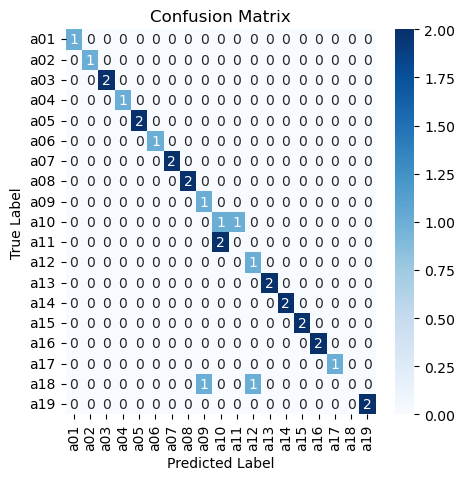

In [45]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test1, y_pred1)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Without PCA

In [46]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)

cv_scores = cross_val_score(clf, X_train1, y_train1, cv=5)
print(f"Cross-validation scores: {cv_scores}") 
print(f"Mean CV score: {np.mean(cv_scores)}")

clf.fit(X_train1, y_train1)
y_pred1 = clf.predict(X_test1)
print(classification_report(y_test1, y_pred1))

Cross-validation scores: [0.92       0.875      0.875      0.91666667 0.91666667]
Mean CV score: 0.9006666666666666
              precision    recall  f1-score   support

         a01       1.00      1.00      1.00         1
         a02       1.00      1.00      1.00         1
         a03       1.00      1.00      1.00         2
         a04       1.00      1.00      1.00         1
         a05       1.00      1.00      1.00         2
         a06       1.00      1.00      1.00         1
         a07       1.00      1.00      1.00         2
         a08       1.00      1.00      1.00         2
         a09       1.00      1.00      1.00         1
         a10       1.00      1.00      1.00         2
         a11       1.00      1.00      1.00         2
         a12       1.00      1.00      1.00         1
         a13       1.00      1.00      1.00         2
         a14       1.00      1.00      1.00         2
         a15       1.00      1.00      1.00         2
         a16       

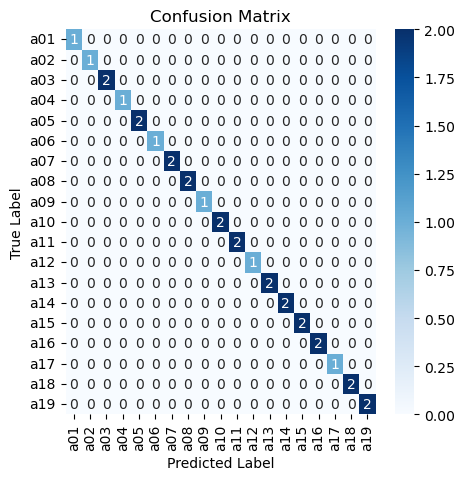

In [47]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test1, y_pred1)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Leave one subject out

In [48]:
column_names = []
for axis in range(0, 45):  # 45 sensors
    column_names.append(f'segment_{axis}_mean')
    column_names.append(f'segment_{axis}_variance')
    column_names.append(f'segment_{axis}_skewness')
    column_names.append(f'segment_{axis}_kurtosis')
    
X_train = pd.DataFrame(X_train , columns=[f'feature_{i}' for i in range(len(X_train[0]))])
X_test = pd.DataFrame(X_test , columns=[f'feature_{i}' for i in range(len(X_test[0]))])

num_rows_train = len(X_train)
num_chunks_train = num_rows_train // 60  # Number of full chunks of 60 rows
num_rows_test = len(X_test)
num_chunks_test = num_rows_test // 60  

# Reshape the data so that each 60 rows become a single row
X_reshaped_train = X_train.values[:num_chunks_train * 60].reshape(num_chunks_train, 60 * X_train.shape[1])
X_reshaped_test = X_test.values[:num_chunks_test * 60].reshape(num_chunks_test, 60 * X_test.shape[1])

reshaped_column_names = []
for i in range(60):  # 60 rows per chunk
    for name in column_names:
        reshaped_column_names.append(f'{name}_row_{i}')

# Convert the reshaped data back into a DataFrame
X_train = pd.DataFrame(X_reshaped_train, columns=[f'feature_{i}' for i in range(X_reshaped_train.shape[1])])
X_test = pd.DataFrame(X_reshaped_test, columns=[f'feature_{i}' for i in range(X_reshaped_test.shape[1])])
X_train.columns = reshaped_column_names
X_test.columns = reshaped_column_names

X_train


,segment_0_mean_row_0,segment_0_variance_row_0,segment_0_skewness_row_0,segment_0_kurtosis_row_0,segment_1_mean_row_0,segment_1_variance_row_0,segment_1_skewness_row_0,segment_1_kurtosis_row_0,segment_2_mean_row_0,segment_2_variance_row_0,...,segment_42_skewness_row_59,segment_42_kurtosis_row_59,segment_43_mean_row_59,segment_43_variance_row_59,segment_43_skewness_row_59,segment_43_kurtosis_row_59,segment_44_mean_row_59,segment_44_variance_row_59,segment_44_skewness_row_59,segment_44_kurtosis_row_59
0,7.975714,1.083150,5.606846,0.004897,0.026123,-0.003726,-0.790726,-0.068490,0.135897,0.679134,...,-0.130655,1.391861,-0.957192,0.523348,0.952636,0.099793,0.478262,0.010011,-0.469147,-0.069317
1,8.416815,0.571528,5.002842,0.003358,0.019363,-0.002707,-0.679956,-0.549639,-0.114602,8.868554,...,-0.397840,0.067150,-0.271745,2.023145,0.089790,0.234017,0.131091,-0.680859,0.998120,-0.255312
2,-4.834646,-0.501018,8.603671,0.002373,0.021227,-0.003346,0.194648,0.533903,-0.725974,-0.606320,...,2.587988,-0.051651,0.578826,0.278633,-0.062430,-0.162288,-0.204487,-0.293883,-0.112958,-0.259735
3,2.249583,-7.764958,5.630419,-0.001820,-0.020747,-0.002954,-0.184934,0.286008,-0.834544,3.837948,...,-0.383257,0.204388,0.063140,-0.551370,-0.084222,-0.178562,0.020258,0.529750,0.351640,-0.449411
4,7.570732,0.044689,2.098112,-0.007116,0.019866,-0.028227,-0.439268,0.411857,-0.344403,-0.549550,...,-0.136240,-0.359147,19.462564,14.021030,1.092031,2.931719,-0.996283,-1.165444,-0.296432,-0.418195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,8.626394,-1.568046,4.285646,0.002045,0.022171,-0.007622,-0.799188,-0.065418,0.058847,-0.610637,...,-1.210604,-0.024128,-0.353521,0.041730,0.014861,-1.281806,-1.417289,-1.187293,-1.553026,-0.878616
129,9.251990,-1.967370,2.263067,-0.005938,0.028369,0.002478,-0.988004,0.525324,0.169924,0.778122,...,-0.418474,-0.472572,-0.298141,1.232836,-0.568332,-0.395254,-1.369146,-1.395256,-1.458112,-0.581196
130,6.535106,-1.123563,1.593553,0.042363,0.004965,0.003014,-0.674965,0.181484,-0.528348,-0.043364,...,0.425819,-0.025228,14.354624,1.696552,2.354164,-0.728516,0.487949,0.222562,-0.838295,0.384838
131,9.469690,-0.616317,2.948960,0.064844,-0.045885,0.034145,-0.788948,0.388281,-0.231306,9.458087,...,-0.601266,-0.378239,3.176929,0.039744,1.046332,1.031028,-0.592885,0.200441,-0.243221,-0.706892


In [49]:
X_test

,segment_0_mean_row_0,segment_0_variance_row_0,segment_0_skewness_row_0,segment_0_kurtosis_row_0,segment_1_mean_row_0,segment_1_variance_row_0,segment_1_skewness_row_0,segment_1_kurtosis_row_0,segment_2_mean_row_0,segment_2_variance_row_0,...,segment_42_skewness_row_59,segment_42_kurtosis_row_59,segment_43_mean_row_59,segment_43_variance_row_59,segment_43_skewness_row_59,segment_43_kurtosis_row_59,segment_44_mean_row_59,segment_44_variance_row_59,segment_44_skewness_row_59,segment_44_kurtosis_row_59
0,7.521169,-0.674383,6.311963,0.004258,0.018442,-0.003131,-0.609843,-0.426120,-0.185021,-2.883730,...,1.367965,0.720732,0.182784,0.123283,0.247231,0.224087,0.159280,1.991765,3.011040,1.932930
1,9.763670,0.368034,0.924728,0.002207,0.028807,-0.006156,-0.747641,0.094195,0.226185,8.573242,...,0.944055,-0.575485,1.441834,-0.202265,-0.190763,0.193009,0.144592,3.972207,0.986288,1.958279
2,-1.717138,-2.205973,9.480472,0.006543,0.024200,-0.003552,-0.010187,0.663007,-0.630166,0.468066,...,3.689245,-0.812141,8.090679,-0.742826,1.811838,0.361370,0.299738,0.947982,4.013943,0.959300
3,2.577028,-9.381730,1.286956,0.003563,0.019130,-0.003624,-0.257757,0.804467,0.396344,5.897840,...,2.377579,0.299944,0.231893,0.373332,-0.007460,1.124936,0.538900,0.802575,1.239497,1.390986
4,9.448002,-0.260726,-2.466120,-0.046781,-0.018003,0.043128,-0.674675,0.620623,0.244992,9.549086,...,-0.907048,0.988537,0.441145,4.599402,-0.177227,-0.826860,-1.168800,-1.271769,-1.451122,-0.989413
5,9.812606,0.163492,-0.172809,-0.077902,0.055026,-0.015077,-0.449853,-0.680862,0.215530,9.144767,...,-0.123133,0.938308,1.996903,0.907169,-0.121990,-0.129073,1.640660,-0.881064,0.186513,0.087643
6,10.068954,0.660786,1.394592,0.018507,0.023177,-0.003084,-0.335914,-0.099911,0.461453,6.669768,...,-0.928287,0.202094,1.621792,1.139590,-0.207440,-0.005003,0.647261,-0.999474,-1.001959,-1.480877
7,9.797046,-0.194670,0.604159,0.003254,0.021782,-0.004353,-0.258352,-0.086513,0.428106,0.141710,...,3.758370,63.089123,31.394553,44.298598,8.094582,8.485545,11.248001,1.400568,1.579290,3.258438
8,9.725889,-0.660535,0.724943,-0.027329,0.015733,-0.034489,-0.796019,-0.081227,0.439499,0.802668,...,-0.646311,1.375101,1.044435,7.122296,-0.119799,0.042479,-0.906070,-1.604217,-1.257869,-0.307581
9,9.638082,-0.151209,1.879270,-0.033656,0.017346,-0.021590,-0.850896,0.091568,-0.570482,9.633334,...,-0.204233,0.973991,2.360224,4.333745,1.878410,1.201891,-0.891612,-1.503375,-1.122670,-1.122666


In [50]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

y_train_reshaped = []
y_test_reshaped = []

for activity in df_all_activities['Activity'].unique():
    activity_data = df_all_activities[df_all_activities['Activity'] == activity]
    num_segments = len(activity_data['Segment'].unique())
    
    # Add the activity label for every chunk of 60 segments
    for i in range(num_segments // 60):  # for every full chunk of 60 segments
        y_train_reshaped.append(activity)
        y_test_reshaped.append(activity)

# Convert y_reshaped into a DataFrame
y_train = pd.DataFrame(y_train_reshaped, columns=["Activity"])
y_train = y_train.values.ravel() 
y_test = pd.DataFrame(y_test_reshaped, columns=["Activity"])
y_test = y_test.values.ravel()

y_train = np.tile(y_train, 7)
y_train


array(['a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08', 'a09',
       'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'a18',
       'a19', 'a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08',
       'a09', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17',
       'a18', 'a19', 'a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07',
       'a08', 'a09', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16',
       'a17', 'a18', 'a19', 'a01', 'a02', 'a03', 'a04', 'a05', 'a06',
       'a07', 'a08', 'a09', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15',
       'a16', 'a17', 'a18', 'a19', 'a01', 'a02', 'a03', 'a04', 'a05',
       'a06', 'a07', 'a08', 'a09', 'a10', 'a11', 'a12', 'a13', 'a14',
       'a15', 'a16', 'a17', 'a18', 'a19', 'a01', 'a02', 'a03', 'a04',
       'a05', 'a06', 'a07', 'a08', 'a09', 'a10', 'a11', 'a12', 'a13',
       'a14', 'a15', 'a16', 'a17', 'a18', 'a19', 'a01', 'a02', 'a03',
       'a04', 'a05', 'a06', 'a07', 'a08', 'a09', 'a10', 'a11', 'a12',
       'a13', 'a14',

In [51]:
X_train_normalized = normalize_data(X_train)
X_train_pca = apply_pca(X_train_normalized, n_components=19)
X_test_normalized = normalize_data(X_test)
X_test_pca = apply_pca(X_test_normalized, n_components=19)
X_train_pca.shape, X_test_pca.shape

((133, 19), (19, 19))

#### With PCA

In [54]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_pca, y_train)

cv_scores = cross_val_score(clf, X_train_pca, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores)}")

clf.fit(X_train_pca, y_train)
y_pred2 = clf.predict(X_test_pca)
y_test2 = y_test
print(classification_report(y_test2, y_pred2))

Cross-validation scores: [0.88888889 0.88888889 0.88888889 0.88461538 0.84615385]
Mean cross-validation score: 0.8794871794871794
              precision    recall  f1-score   support

         a01       0.00      0.00      0.00         1
         a02       0.00      0.00      0.00         1
         a03       0.00      0.00      0.00         1
         a04       0.00      0.00      0.00         1
         a05       0.00      0.00      0.00         1
         a06       0.00      0.00      0.00         1
         a07       0.00      0.00      0.00         1
         a08       0.00      0.00      0.00         1
         a09       0.00      0.00      0.00         1
         a10       0.00      0.00      0.00         1
         a11       0.00      0.00      0.00         1
         a12       0.00      0.00      0.00         1
         a13       0.00      0.00      0.00         1
         a14       0.00      0.00      0.00         1
         a15       0.00      0.00      0.00         1
     

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


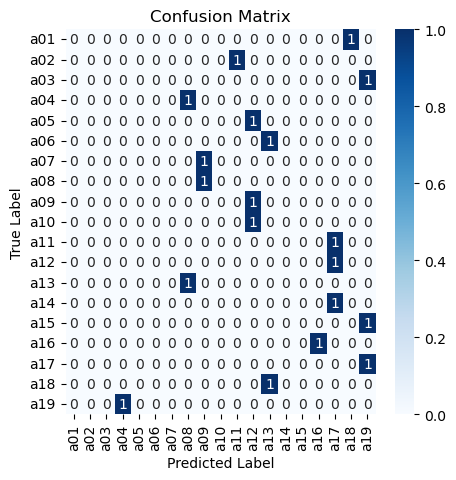

In [55]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test2, y_pred2)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Without PCA

In [52]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores)}")

clf.fit(X_train, y_train)
y_pred2 = clf.predict(X_test)
y_test2 = y_test
print(classification_report(y_test2, y_pred2))

Cross-validation scores: [0.96296296 0.92592593 0.92592593 0.92307692 0.92307692]
Mean cross-validation score: 0.9321937321937324
              precision    recall  f1-score   support

         a01       1.00      1.00      1.00         1
         a02       1.00      1.00      1.00         1
         a03       1.00      1.00      1.00         1
         a04       1.00      1.00      1.00         1
         a05       1.00      1.00      1.00         1
         a06       1.00      1.00      1.00         1
         a07       1.00      1.00      1.00         1
         a08       1.00      1.00      1.00         1
         a09       0.00      0.00      0.00         1
         a10       0.50      1.00      0.67         1
         a11       1.00      1.00      1.00         1
         a12       1.00      1.00      1.00         1
         a13       1.00      1.00      1.00         1
         a14       1.00      1.00      1.00         1
         a15       1.00      1.00      1.00         1
     

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


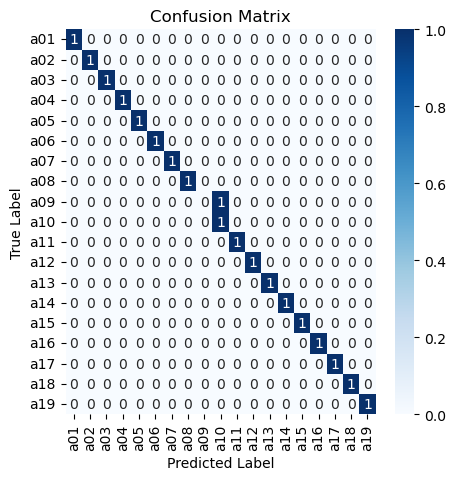

In [53]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test2, y_pred2)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Exercise 2 Reflection

In both cases, I got worse results when I applied PCA. In the case of the leave-one-person-out strategy, WAY worse results with PCA. The dimensionality reduction may have been too aggressive and caused the model to lose important features necessary for optimal learning. With more time, I would have figured out which features were most important and made sure to keep those when applyiing PCA. Overall, both train-test split strategies resulted in fairly high accuracy. The most difficult part was organizing the data and extracting the features in an interpretable way.